# STA 380, Part 2: Exercises

In [57]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import nltk
import os
import re
import tqdm
from collections import Counter
from nltk.corpus import reuters, stopwords
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from sklearn.feature_extraction.text import TfidfVectorizer

## **Probability Practice**

### Part A:

Visitors to your website are asked to answer a single survey question before they get access to the content on the page. Among all of the users, there are two categories: Random Clicker (RC), and Truthful Clicker (TC). There are two possible answers to the survey: yes and no. Random clickers would click either one with equal probability. You are also giving the information that the expected fraction of random clickers is 0.3. After a trial period, you get the following survey results: 65% said Yes and 35% said No. What fraction of people who are truthful clickers answered yes? Hint: use the rule of total probability.

**Solution:**

Using the total law of probability, we know that 

\begin{equation*}
P(yes) = P(yes\mid{TC})P(TC) + P(yes\mid{RC})P(RC)
\end{equation*}

We know that $P(yes) = 0.65$, $P(RC) = 0.3$, $P(yes\mid{RC}) = 0.5$ and $P(TC) = 1-0.3 = 0.7$. Thus, this means we can solve for the probability we are interested in.

\begin{align*}
P(yes) &= P(yes\mid{TC})P(TC) + P(yes\mid{RC})P(RC) \\
0.65 &= P(yes\mid{TC}) \cdot 0.7 + 0.5 \cdot 0.3 \\
P(yes\mid{TC}) &= \frac{0.65-0.15}{0.7} \\
P(yes\mid{TC}) &= \frac{5}{7} 
\end{align*}

### Part B: 

Imagine a medical test for a disease with the following two attributes:

The sensitivity is about 0.993. That is, if someone has the disease, there is a probability of 0.993 that they will test positive.
The specificity is about 0.9999. This means that if someone doesn't have the disease, there is probability of 0.9999 that they will test negative.
In the general population, incidence of the disease is reasonably rare: about 0.0025% of all people have it (or 0.000025 as a decimal probability).
Suppose someone tests positive. What is the probability that they have the disease?

**Solution:**

Using Bayes's Theorem, we can can find the conditional probability $P(disease\mid{positive})$. We are given $P(positive\mid{disease}) = 0.993$ and we have that $P(negative\mid{no \ disease}) = 0.9999$, $P(disease) = 0.000025$.

\begin{align*}
P(disease\mid{positive}) &= \frac{P(positive\mid{disease})P(disease)}{P(disease)} \\
&=  \frac{P(positive\mid{disease})P(disease)}{P(positive\mid{disease})P(disease) + P(positive\mid{no \ disease})P(no \ disease)} \\
&=  \frac{0.993 \cdot 0.000025}{0.993 \cdot 0.000025 + (1-0.9999)\cdot (1-0.000025)} \\
&= 19.89\%
\end{align*}

## **Wrangling the Billboard Top 100**
Consider the data in billboard.csv containing every song to appear on the weekly Billboard Top 100 chart since 1958, up through the middle of 2021. Each row of this data corresponds to a single song in a single week. For our purposes, the relevant columns here are:

- performer: who performed the song
- song: the title of the song
- year: year (1958 to 2021)
- week: chart week of that year (1, 2, etc)
- week_position: what position that song occupied that week on the Billboard top 100 chart.
Use your skills in data wrangling and plotting to answer the following three questions.

### Part A

Make a table of the top 10 most popular songs since 1958, as measured by the total number of weeks that a song spent on the Billboard Top 100. Note that these data end in week 22 of 2021, so the most popular songs of 2021 will not have up-to-the-minute data; please send our apologies to The Weeknd.

Your table should have 10 rows and 3 columns: `performer`, `song`, and `count`, where `count` represents the number of weeks that song appeared in the Billboard Top 100. Make sure the entries are sorted in descending order of the `count` variable, so that the more popular songs appear at the top of the table. Give your table a short caption describing what is shown in the table.

(Note: you'll want to use both `performer` and `song` in any `group_by` operations, to account for the fact that multiple unique songs can share the same title.)

In [2]:
billboard = pd.read_csv('billboard.csv')
songs = billboard.groupby(['song', 'performer'])[['weeks_on_chart']].count()
pop_10_songs = songs.sort_values(by='weeks_on_chart', ascending=False)[:10]
pop_10_songs = pop_10_songs.rename(columns={'weeks_on_chart':'count'})
pop_10_songs.style.set_caption("This table shows the song, who sang it and how many weeks it appeared for on the Billboard Top 100.") 

### Part B:

Is the "musical diversity" of the Billboard Top 100 changing over time? Let's find out. We'll measure the musical diversity of given year as the number of unique songs that appeared in the Billboard Top 100 that year. Make a line graph that plots this measure of musical diversity over the years. The x axis should show the year, while the y axis should show the number of unique songs appearing at any position on the Billboard Top 100 chart in any week that year. For this part, please filter the data set so that it excludes the years 1958 and 2021, since we do not have complete data on either of those years. Give the figure an informative caption in which you explain what is shown in the figure and comment on any interesting trends you see.

There are number of ways to accomplish the data wrangling here. For example, you could use two distinct sets of data-wrangling steps. The first set of steps would get you a table that counts the number of times that a given song appears on the Top 100 in a given year. The second set of steps operate on the result of the first set of steps; it would count the number of unique songs that appeared on the Top 100 in each year, irrespective of how many times it had appeared.

Text(0.5, -0.1, "The figure shows the number of unique songs that had at least one stint in the top 100. We see that near the 1960's to the 1970's, there were a large number of unique songs in the top 100, but then it decline until recently when it started to increase again.")

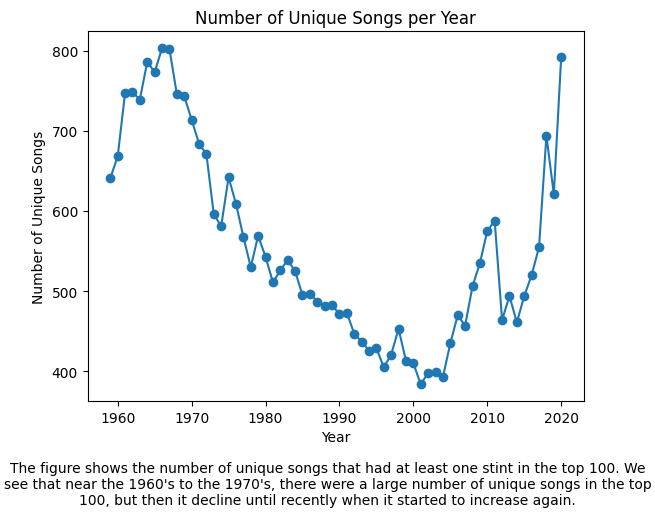

In [3]:
mask = billboard['week_position'] <= 100
billboard = billboard[mask]

unique_songs_per_year = billboard.groupby('year')['song'].nunique()[1:-1]

fig = plt.figure()
plt.plot(unique_songs_per_year.index.values, unique_songs_per_year.values)
plt.scatter(unique_songs_per_year.index.values, unique_songs_per_year.values)
plt.xlabel("Year")
plt.ylabel("Number of Unique Songs")
plt.title("Number of Unique Songs per Year")

txt = 'The figure shows the number of unique songs that had at least one stint in the top 100. We see that near the 1960\'s to the 1970\'s, there were a large number of unique songs in the top 100, but then it decline until recently when it started to increase again.'
fig.text(.5, -.1, txt, ha='center', wrap=True)

### Part C:

Let's define a "ten-week hit" as a single song that appeared on the Billboard Top 100 for at least ten weeks. There are 19 artists in U.S. musical history since 1958 who have had at least 30 songs that were "ten-week hits." Make a bar plot for these 19 artists, showing how many ten-week hits each one had in their musical career. Give the plot an informative caption in which you explain what is shown.

Text(10, 22, 'The barplot represents all artists who had at least 30 songs that were ten-week hits. ')

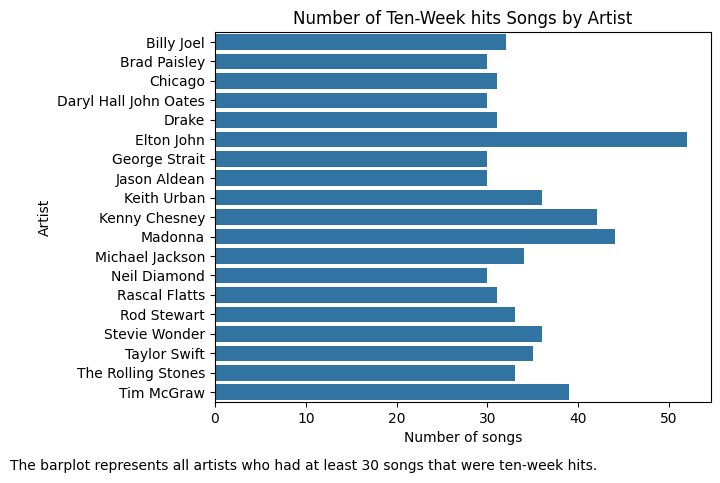

In [4]:
mask = billboard['weeks_on_chart'] >= 10
ten_week_hits = billboard[mask]
artists = ten_week_hits.groupby('performer')[['song']].nunique()

best_30 = artists[artists['song'] >= 30]
ax = sns.barplot(best_30, x='song', y='performer')
ax.set_title("Number of Ten-Week hits Songs by Artist")
ax.set_xlabel("Number of songs")
ax.set_ylabel("Artist")
txt = 'The barplot represents all artists who had at least 30 songs that were ten-week hits. '
ax.text(10, 22, txt, ha='center')

## **Visual story telling part 1: green buildings**

### The case

Over the past decade, both investors and the general public have paid increasingly close attention to the benefits of environmentally conscious buildings. There are both ethical and economic forces at work here. In commercial real estate, issues of eco-friendliness are intimately tied up with ordinary decisions about how to allocate capital. In this context, the decision to invest in eco-friendly buildings could pay off in at least four ways.

1. Every building has the obvious list of recurring costs: water, climate control, lighting, waste disposal, and so forth. Almost by definition, these costs are lower in green buildings.
2. Green buildings are often associated with better indoor environments—the kind that are full of sunlight, natural materials, and various other humane touches. Such environments, in turn, might result in higher employee productivity and lower absenteeism, and might therefore be more coveted by potential tenants. The financial impact of this factor, however, is rather hard to quantify ex ante; you cannot simply ask an engineer in the same way that you could ask a question such as, “How much are these solar panels likely to save on the power bill?”
3. Green buildings make for good PR. They send a signal about social responsibility and ecological awareness, and might therefore command a premium from potential tenants who want their customers to associate them with these values. It is widely believed that a good corporate image may enable a firm to charge premium prices, to hire better talent, and to attract socially conscious investors.
4. Finally, sustainable buildings might have longer economically valuable lives. For one thing, they are expected to last longer, in a direct physical sense. (One of the core concepts of the green-building movement is “life-cycle analysis,” which accounts for the high front-end environmental impact of ac- quiring materials and constructing a new building in the first place.) Moreover, green buildings may also be less susceptible to market risk—in particular, the risk that energy prices will spike, driving away tenants into the arms of bolder, greener investors.

Of course, much of this is mere conjecture. At the end of the day, tenants may or may not be willing to pay a premium for rental space in green buildings. We can only find out by carefully examining data on the commercial real-estate market.

The file greenbuildings.csv contains data on 7,894 commercial rental properties from across the United States. Of these, 685 properties have been awarded either LEED or EnergyStar certification as a green building. You can easily find out more about these rating systems on the web, e.g. at www.usgbc.org. The basic idea is that a commercial property can receive a green certification if its energy efficiency, carbon footprint, site selection, and building materials meet certain environmental benchmarks, as certified by outside engineers.

A group of real estate economists constructed the data in the following way. Of the 1,360 green-certified buildings listed as of December 2007 on the LEED or EnergyStar websites, current information about building characteristics and monthly rents were available for 685 of them. In order to provide a control population, each of these 685 buildings was matched to a cluster of nearby commercial buildings in the CoStar database. Each small cluster contains one green-certified building, and all non-rated buildings within a quarter-mile radius of the certified building. On average, each of the 685 clusters contains roughly 12 buildings, for a total of 7,894 data points.

The columns of the data set are coded as follows:

- CS.PropertyID: the building's unique identifier in the CoStar database.
- cluster: an identifier for the building cluster, with each cluster containing one green-certified building and at least one other non-green-certified building within a quarter-mile radius of the cluster center.
- size: the total square footage of available rental space in the building.
- empl.gr: the year-on-year growth rate in employment in the building's geographic region.
- Rent: the rent charged to tenants in the building, in dollars per square foot per calendar year.
- leasing.rate: a measure of occupancy; the fraction of the building's available space currently under lease.
- stories: the height of the building in stories.
- age: the age of the building in years.
- renovated: whether the building has undergone substantial renovations during its lifetime.
- class.a, class.b: indicators for two classes of building quality (the third is Class C). These are relative classifications within a specific market. Class A buildings are generally the highest-quality properties in a given market. Class B buildings are a notch down, but still of reasonable quality. Class C buildings are the least desirable properties in a given market.
- green.rating: an indicator for whether the building is either LEED- or EnergyStar-certified.
- LEED, Energystar: indicators for the two specific kinds of green certifications.
- net: an indicator as to whether the rent is quoted on a "net contract" basis. Tenants with net-rental contracts pay their own utility costs, which are otherwise included in the quoted rental price.
- amenities: an indicator of whether at least one of the following amenities is available on-site: bank, convenience store, dry cleaner, restaurant, retail shops, fitness center.
- cd.total.07: number of cooling degree days in the building's region in 2007. A degree day is a measure of demand for energy; higher values mean greater demand. Cooling degree days are measured relative to a baseline outdoor temperature, below which a building needs no cooling.
- hd.total07: number of heating degree days in the building's region in 2007. Heating degree days are also measured relative to a baseline outdoor temperature, above which a building needs no heating.
- total.dd.07: the total number of degree days (either heating or cooling) in the building's region in 2007.
- Precipitation: annual precipitation in inches in the building's geographic region.
- Gas.Costs: a measure of how much natural gas costs in the building's geographic region.
- Electricity.Costs: a measure of how much electricity costs in the building's geographic region.
- cluster.rent: a measure of average rent per square-foot per calendar year in the building's local market.

### The goal

An Austin real-estate developer is interested in the possible economic impact of "going green" in her latest project: a new 15-story mixed-use building on East Cesar Chavez, just across I-35 from downtown. Will investing in a green building be worth it, from an economic perspective? The baseline construction costs are $100 million, with a 5% expected premium for green certification.

The developer has had someone on her staff, who's been described to her as a "total Excel guru from his undergrad statistics course," run some numbers on this data set and make a preliminary recommendation. Here's how this person described his process.

**"I began by cleaning the data a little bit. In particular, I noticed that a handful of the buildings in the data set had very low occupancy rates (less than $10\%$ of available space occupied). I decided to remove these buildings from consideration, on the theory that these buildings might have something weird going on with them, and could potentially distort the analysis. Once I scrubbed these low-occupancy buildings from the data set, I looked at the green buildings and non-green buildings separately. The median market rent in the non-green buildings was $\$25$ per square foot per year, while the median market rent in the green buildings was $\$27.60$ per square foot per year: about $\$2.60$ more per square foot. (I used the median rather than the mean, because there were still some outliers in the data, and the median is a lot more robust to outliers.) Because our building would be 250,000 square feet, this would translate into an additional $\$250000 \times 2.6 = \$650000$ of extra revenue per year if we build the green building.**

**Our expected baseline construction costs are $\$100$ million, with a $5\%$ expected premium for green certification. Thus we should expect to spend an extra $\$5$ million on the green building. Based on the extra revenue we would make, we would recuperate these costs in $\$5000000/650000 = 7.7$ years. Even if our occupancy rate were only $90\%$, we would still recuperate the costs in a little over 8 years. Thus from year 9 onwards, we would be making an extra $\$650,000$ per year in profit. Since the building will be earning rents for 30 years or more, it seems like a good financial move to build the green building."**

The developer listened to this recommendation, understood the analysis, and still felt unconvinced. She has therefore asked you to revisit the report, so that she can get a second opinion.

Do you agree with the conclusions of her on-staff stats guru? If so, point to evidence supporting his case. If not, explain specifically where and why the analysis goes wrong, and how it can be improved. Do you see the possibility of confounding variables for the relationship between rent and green status? If so, provide evidence for confounding, and see if you can also make a picture that visually shows how we might "adjust" for such a confounder. Tell your story in pictures, with appropriate introductory and supporting text.

Note: this is intended as an exercise in visual and numerical story-telling. Your approach should rely on pictures and/or tables, not a regression model. Tell a story understandable to a non-technical audience. Keep it concise.

### Secondary Analysis

**Introduction:**

Our goal is to determine if the analyst's assessment of the rent being a significant predictor of the green status is accurate. To determine this, it is necessary to see if there are confounding variables affecting the relationship. One note of interest is whether the analyst's decision to drop observations where the occupancy rate was abnormally low was reasonable.

In [58]:
green_buildings = pd.read_csv('greenbuildings.csv')
green_buildings = green_buildings.dropna()
green_buildings.head()

CS_PropertyID  cluster    size  empl_gr   Rent  leasing_rate  stories  age  \
0         379105        1  260300     2.22  38.56         91.39       14   16   
1         122151        1   67861     2.22  28.57         87.14        5   27   
2         379839        1  164848     2.22  33.31         88.94       13   36   
3          94614        1   93372     2.22  35.00         97.04       13   46   
4         379285        1  174307     2.22  40.69         96.58       16    5   

   renovated  class_a  ...  green_rating  net  amenities  cd_total_07  \
0          0        1  ...             1    0          1         4988   
1          0        0  ...             0    0          1         4988   
2          1        0  ...             0    0          1         4988   
3          1        0  ...             0    0          0         4988   
4          0        1  ...             0    0          1         4988   

   hd_total07  total_dd_07  Precipitation  Gas_Costs  Electricity_Costs  \
0          58         5046          42.57   0.013700           0.029000   
1          58         5046          42.57   0.013731           0.029045   
2          58         5046          42.57   0.013731           0.029045   
3          58         5046          42.57   0.013731           0.029045   
4          58         5046          42.57   0.013731           0.029045   

   cluster_rent  
0         36.78  
1         36.78  
2         36.78  
3         36.78  
4         36.78  

[5 rows x 23 columns]

In [59]:
print(green_buildings.groupby('green_rating')['Rent'].median())

mask = green_buildings['leasing_rate'] >= 10
print(green_buildings[mask].groupby('green_rating')['Rent'].median())

green_rating
0    25.0
1    27.6
Name: Rent, dtype: float64
green_rating
0    25.06
1    27.60
Name: Rent, dtype: float64


Text(0.5, 1.0, 'Rent Distribution with all leasing rates')

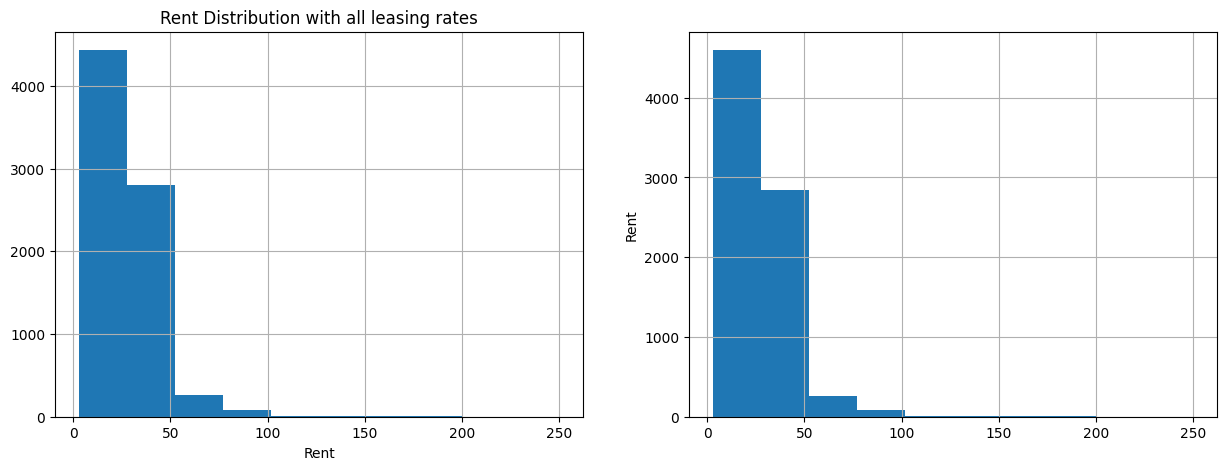

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
green_buildings[mask]['Rent'].hist(ax=axes[0])
axes[0].set_xlabel('Rent')
axes[0].set_title('Rent Distribution with >10% leasing rate')

green_buildings['Rent'].hist(ax=axes[1])
axes[1].set_ylabel('Rent')
axes[0].set_title('Rent Distribution with all leasing rates')

Just as initial analysis, there was a slight difference in the median values of non-green and green buildings when removing the low occupancy rate data points. The histogram also shows that there was almost no discernible change when removing these low occupancy buildings. It seems to make sense to keep these buildings in the dataset to make sure that the analysis is as unbiased as possible. Without good reason, it does not seem justified to remove these rows.

Proportion of clusters where building a green house would not make a profit: 26.491994%


Text(0.5, 1.0, 'Median Housing Rent Per Cluster For Green/Non-green homes')

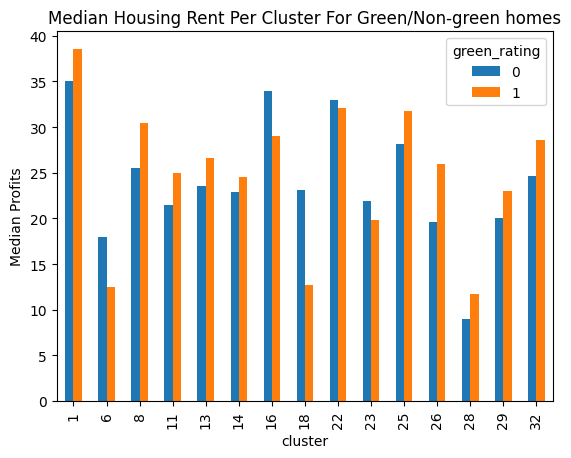

In [31]:
cluster_median_rents = green_buildings.groupby(['cluster', 'green_rating'])[['Rent']].median().unstack()['Rent']
cluster_median_rents['profit_diff'] = cluster_median_rents.apply(lambda x: (x[1]-x[0])*250000, axis=1)

mask = cluster_median_rents['profit_diff'] < 0

print("Proportion of clusters where building a green house would not make a profit: {:4f}%".
      format(len(cluster_median_rents[mask])/len(cluster_median_rents)*100))

cluster_median_rents[:15].drop(columns=['profit_diff']).plot(kind='bar')
plt.ylabel('Median Profits')
plt.title('Median Housing Rent Per Cluster For Green/Non-green homes')

If we group by clusters and consider all buildings, we see that about $26.55\%$ of these clusters would produce a loss when building a green building, which is not insignificant. Thus, the cluster in which you build a green building may be significant and the analyst should have taken this into account. Of course, this is still in line with the analyst's predictions as it is more likely to make a profit on building a green building than a loss.

In [32]:
class_a_median_rents = green_buildings.groupby(['class_a', 'green_rating'])[['Rent']].median().unstack()['Rent']
class_a_median_rents['profit_diff'] = class_a_median_rents.apply(lambda x: (x[1]-x[0])*250000, axis=1)
class_a_median_rents

green_rating       0      1  profit_diff
class_a                                 
0             23.445  25.55     526250.0
1             28.200  28.44      60000.0

In [21]:
class_b_median_rents = green_buildings.groupby(['class_b', 'green_rating'])[['Rent']].median().unstack()['Rent']
class_b_median_rents['profit_diff'] = class_b_median_rents.apply(lambda x: (x[1]-x[0])*250000, axis=1)
class_b_median_rents

green_rating      0      1  profit_diff
class_b                                
0             25.74  28.44     675000.0
1             24.00  25.10     275000.0

In [22]:
class_c_median_rents = green_buildings
class_c_median_rents['class_c'] = green_buildings.apply(lambda x: 1 if (x['class_a'] == 0 and x['class_b'] == 0) else 0, axis=1)
class_c_median_rents = green_buildings.groupby(['class_c', 'green_rating'])[['Rent']].median().unstack()['Rent']
class_c_median_rents['profit_diff'] = class_c_median_rents.apply(lambda x: (x[1]-x[0])*250000, axis=1)
class_c_median_rents

green_rating      0     1  profit_diff
class_c                               
0             25.77  27.6     457500.0
1             22.04  32.0    2490000.0

When we look at the median rent prices of green vs non green houses for Class A, B and C type buildings, given the analyst's findings, the tables above seem to support the idea that green buildings will make more money off of rent. However, looking at class A buildings, the projected profit is only about $\$60,000$. The break even time would be much greater than what the analyst predicted. It is similar for class B buildings, where the profit is slightly lower than what the analyst projected and thus the break even time is different. The only type of building that bolsters the analyst's findings are class C buildings. 

Text(0.5, 1.0, 'Median House Rent given renovated status for green/non-green buildings')

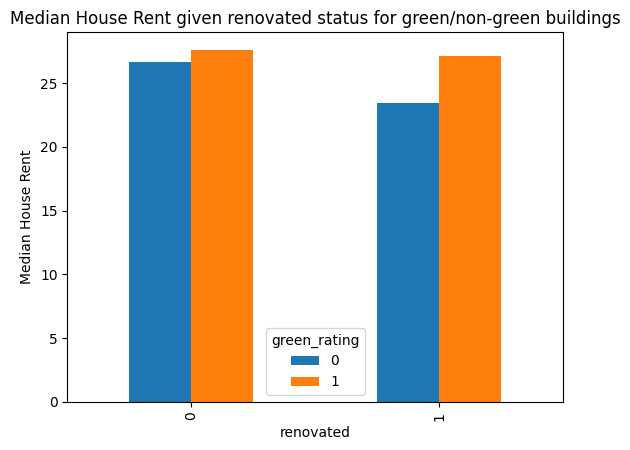

In [33]:
renovated = green_buildings.groupby(['renovated', 'green_rating'])[['Rent']].median().unstack()['Rent']
renovated.plot(kind='bar')
plt.ylabel('Median House Rent')
plt.title('Median House Rent given renovated status for green/non-green buildings')

We see that the renovated status of the buildings does not really affect the relationship between rent and its green status- for both recently and older buildings, the median rent amount is still higher for green buildings.

Text(0.5, 1.0, 'Rent vs Leasing Occupancy Effect on Green Rating')

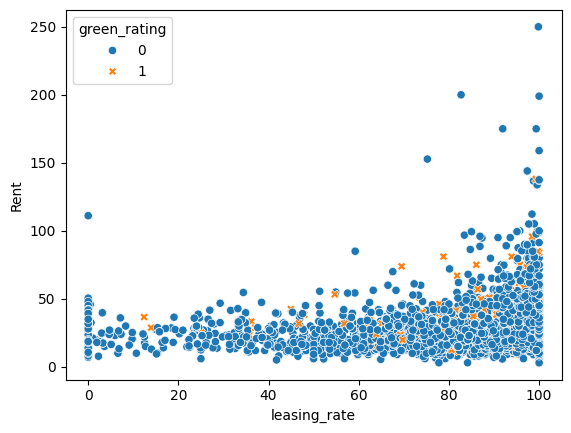

In [45]:
sns.scatterplot(data=green_buildings, x='leasing_rate', y='Rent', hue='green_rating', style='green_rating')
plt.set_title("Rent vs Leasing Occupancy Effect on Green Rating")

When introducing the leasing rate, the relationship between rent and green rating has suddenly become unclear, suggesting that leasing rate can be considered as a confounding variable. There doesn't seem to be any clear benefit from building a green home compared to a non-green home in terms of the leasing rate. In fact, for higher leasing rates, it seems more beneficial to build a non green home instead. Furthermore, there doesn't seem to be evidence that a green building will attract more people compared to non-green buildings. The analyst presumed benefits for at least a $90\%$ leasing rate when building a green building, but it makes sense to build a non green building where it is not even necessary to pay the premium, meaning costs are recuperated faster.

Text(0.5, 1.0, 'Rent vs Electricity Costs Effect on Green Rating for Net Contracts')

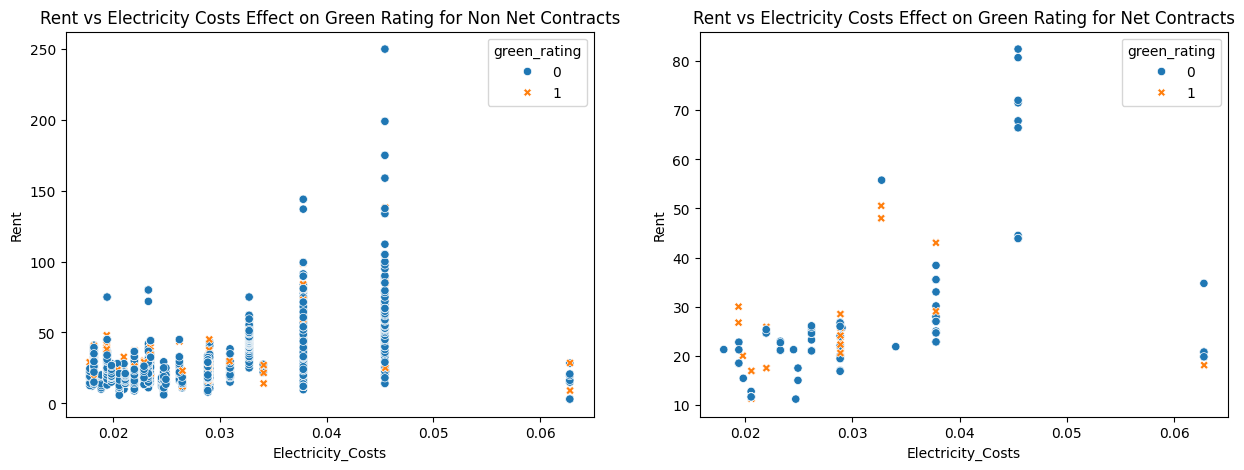

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot(data=green_buildings[(green_buildings['net'] == 0) & (green_buildings['leasing_rate'] >= 90)], x='Electricity_Costs', y='Rent', hue='green_rating', style='green_rating', ax=axes[0])
axes[0].set_title("Rent vs Electricity Costs Effect on Green Rating for Non Net Contracts")

sns.scatterplot(data=green_buildings[(green_buildings['net'] == 1) & (green_buildings['leasing_rate'] >= 90)], x='Electricity_Costs', y='Rent', hue='green_rating', style='green_rating', ax=axes[1])
axes[1].set_title("Rent vs Electricity Costs Effect on Green Rating for Net Contracts")

Text(0.5, 1.0, 'Rent vs Gas Costs Effect on Green Rating for Net Contracts')

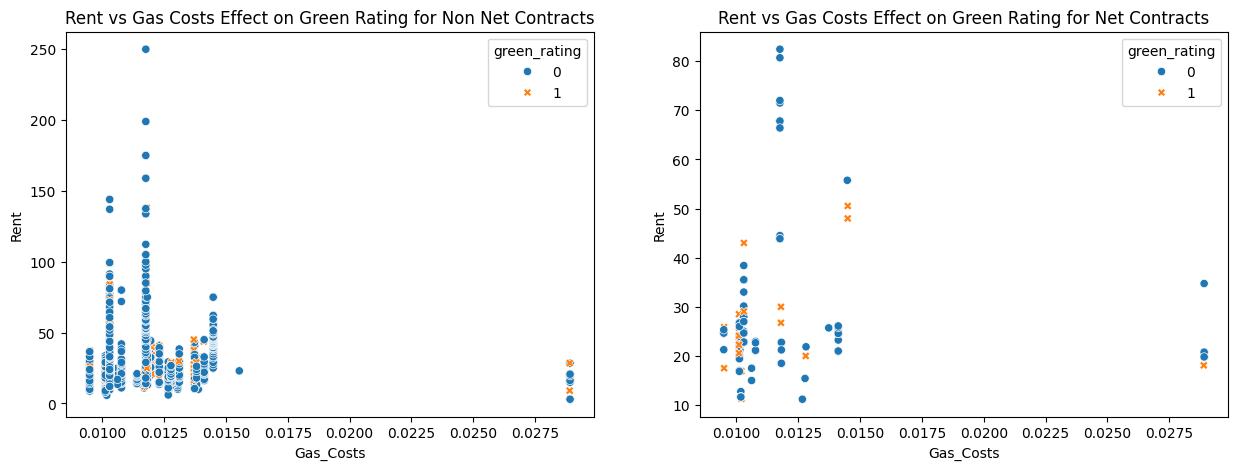

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot(data=green_buildings[(green_buildings['net'] == 0) & (green_buildings['leasing_rate'] >= 90)], x='Gas_Costs', y='Rent', hue='green_rating', style='green_rating', ax=axes[0])
axes[0].set_title("Rent vs Gas Costs Effect on Green Rating for Non Net Contracts")

sns.scatterplot(data=green_buildings[(green_buildings['net'] == 1) & (green_buildings['leasing_rate'] >= 90)], x='Gas_Costs', y='Rent', hue='green_rating', style='green_rating', ax=axes[1])
axes[1].set_title("Rent vs Gas Costs Effect on Green Rating for Net Contracts")

One of the presumed benefits of building a green building is that the gas costs and the electricity costs should be lower, and if the rent is high, then profits are maximized. We thus analyze what rent costs look like in relation to gas and electricity costs, focusing on buildings that ask renters to pay for their own utilities and those who include it in the rent. We also analyze this for a $90\%$ or greater leasing rate.

However, we see that for electricity costs, even when it is low, non-green buildings are still bringing in a large amount of rent compared to non-green buildings. It is similar for gas costs- non green buildings have low gas costs yet they are also charging high rent costs. In general, for both electricity costs and gas costs, the rent of a non green building is higher than that of a green building for most of the various prices. 

Text(0.5, 1.0, 'Rent vs Cooling Costs Effect on Green Rating for Net Contracts')

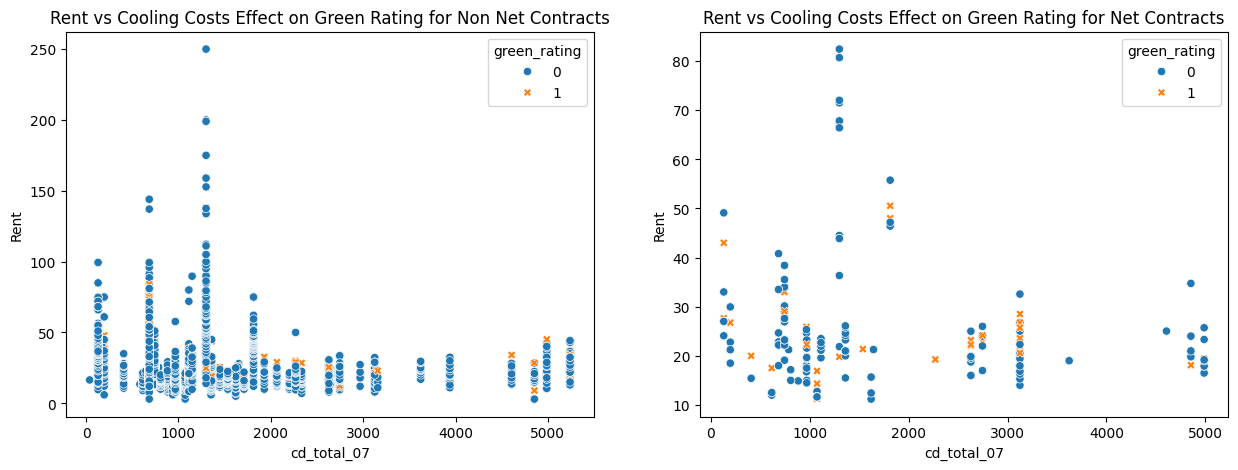

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot(data=green_buildings[green_buildings['net'] == 0], x='cd_total_07', y='Rent', hue='green_rating', style='green_rating', ax=axes[0])
axes[0].set_title("Rent vs Cooling Costs Effect on Green Rating for Non Net Contracts")

sns.scatterplot(data=green_buildings[green_buildings['net'] == 1], x='cd_total_07', y='Rent', hue='green_rating', style='green_rating', ax=axes[1])
axes[1].set_title("Rent vs Cooling Costs Effect on Green Rating for Net Contracts")

Even when there are lower cooling costs, the rent of a non-green building is usually higher than that of the green building. Thus, it makes sense to build non-green buildings as many buildings have lower cost of cooling while also having higher rents to increase profits.

### Conclusion
It appears that the Excel analyst wasn't being necessarily untruthful when saying that the green buildings should be more profitable than the non-green buildings on average. However, when introducing a third variable into the analysis, the results are no longer as clear. For example, when analyzing the effect of median rent between green and non green houses in clusters, not every cluster returned a profit based off of the analyst's calculations. 

Depending on the type of class building, we also see that even though green houses seemed to make more profit off of rent on average compared to non green houses, some classes had a much different timeline to recouping and then making profits off of the rent prices. Thus, it contradicts the analyst's belief of the period of time it will take to recoup costs as it is actually variable given the type of building he wants to construct.

When looking at gas and electricity prices, non-green houses seemed to charge more in rent compared to green homes while also maintaining low utility costs. This of course contradicted the findings found by the analyst as it is not clear whether a green building will make a significant profit compared to non-green buildings. It is a similar case for cooling costs.

Ultimately, the issue with the analysis is the number of observations being heavily imbalanced. Many of these variables have a particularly significant confounding effect since the number of green buildings is significantly less than the number of non green buildings, meaning a significant sample size imbalance. Without enough green houses to analyze, the effects of possible confounding variables can increase.

## **Visual story telling part 2: Capital Metro data**

The file capmetro_UT.csv contains data from Austin's own Capital Metro bus network, including shuttles to, from, and around the UT campus. These data track ridership on buses in the UT area. Ridership is measured by an optical scanner that counts how many people embark and alight the bus at each stop. Each row in the data set corresponds to a 15-minute period between the hours of 6 AM and 10 PM, each and every day, from September through November 2018. The variables are:

- timestamp: the beginning of the 15-minute window for that row of data
- boarding: how many people got on board any Capital Metro bus on the UT campus in the specific 15 minute window
- alighting: how many people got off ("alit") any Capital Metro bus on the UT campus in the specific 15 minute window
- day_of_week and weekend: Monday, Tuesday, etc, as well as an indicator for whether it's a weekend.
- temperature: temperature at that time in degrees F
- hour_of_day: on 24-hour time, so 6 for 6 AM, 13 for 1 PM, 14 for 2 PM, etc.
- month: July through December

Your task is to create a figure, or set of related figures, that tell an interesting story about Capital Metro ridership patterns around the UT-Austin campus during the semester in question. Provide a clear annotation/caption for each figure, but the figure(s) should be more or less stand-alone, in that you shouldn't need many, many paragraphs to convey its meaning. Rather, the figure together with a concise caption should speak for itself as far as possible.

You have broad freedom to look at any variables you'd like here -- try to find that sweet spot where you're showing genuinely interesting relationships among more than just two variables, but where the resulting figure or set of figures doesn't become overwhelming/confusing. (Faceting/panel plots might be especially useful here.)

In [68]:
capmetro_UT = pd.read_csv('capmetro_UT.csv')
capmetro_UT['timestamp'] = pd.to_datetime(capmetro_UT['timestamp'])
capmetro_UT.head()

timestamp  boarding  alighting day_of_week  temperature  \
0 2018-09-01 06:00:00         0          1         Sat        74.82   
1 2018-09-01 06:15:00         2          1         Sat        74.82   
2 2018-09-01 06:30:00         3          4         Sat        74.82   
3 2018-09-01 06:45:00         3          4         Sat        74.82   
4 2018-09-01 07:00:00         2          4         Sat        74.39   

   hour_of_day month  weekend  
0            6   Sep  weekend  
1            6   Sep  weekend  
2            6   Sep  weekend  
3            6   Sep  weekend  
4            7   Sep  weekend

Text(0.5, 1.0, 'Boarding Numbers by Temperature for Weekends vs Weekdays')

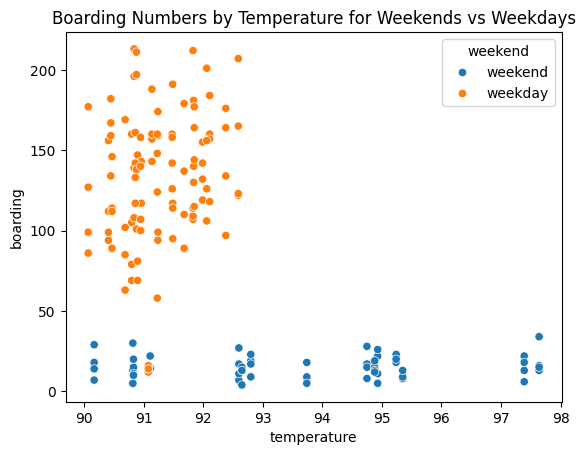

In [71]:
sns.scatterplot(data=capmetro_UT[capmetro_UT['temperature'] >= 90], x='temperature', y='boarding', hue='weekend')
plt.title('Boarding Numbers by Temperature for Weekends vs Weekdays')

Text(0.5, 1.0, 'Alighting Numbers by Temperature for Weekends vs Weekdays')

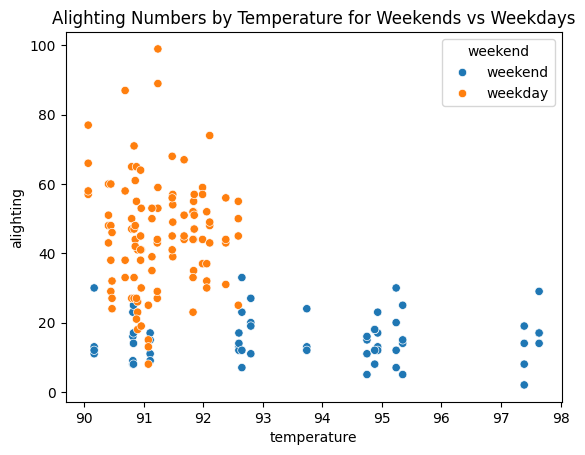

In [72]:
sns.scatterplot(data=capmetro_UT[capmetro_UT['temperature'] >= 90], x='temperature', y='alighting', hue='weekend')
plt.title('Alighting Numbers by Temperature for Weekends vs Weekdays')

Text(0, 0.5, 'Temperature')

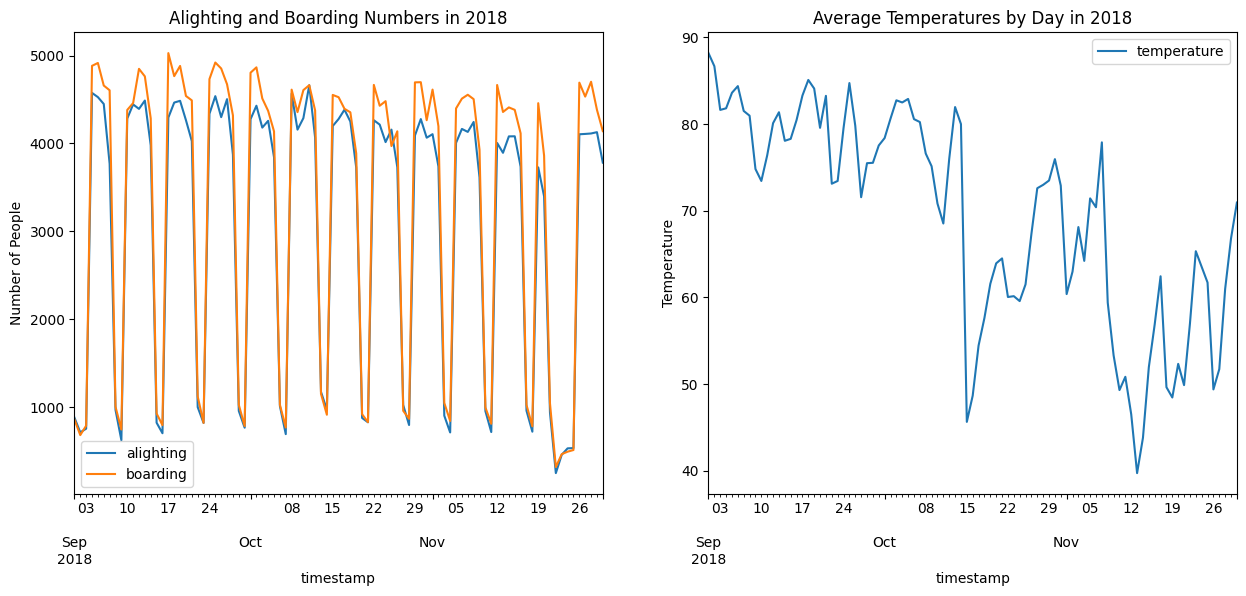

In [70]:
# Look at Time series
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

capmetro_UT.resample('D', on='timestamp')[['alighting', 'boarding']].sum().plot(ax=axes[0])
axes[0].set_title("Alighting and Boarding Numbers in 2018")
axes[0].set_ylabel("Number of People")

capmetro_UT.resample('D', on='timestamp')[['temperature']].mean().plot(ax=axes[1])
axes[1].set_title("Average Temperatures by Day in 2018")
axes[1].set_ylabel("Temperature")

Text(0.5, 1.0, 'Alighting and Boarding Numbers by Weekday/Weekend')

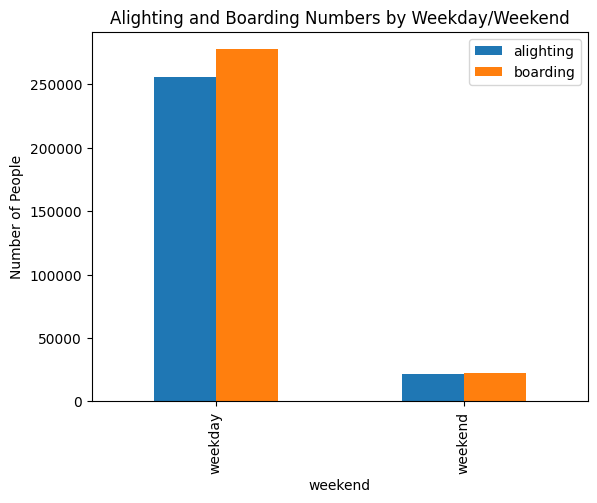

In [20]:
capmetro_UT.groupby('weekend')[['alighting', 'boarding']].sum().plot(kind='bar')
plt.ylabel("Number of People")
plt.title('Alighting and Boarding Numbers by Weekday/Weekend')

Text(0.5, 1.0, 'Alighting vs Day of Week')

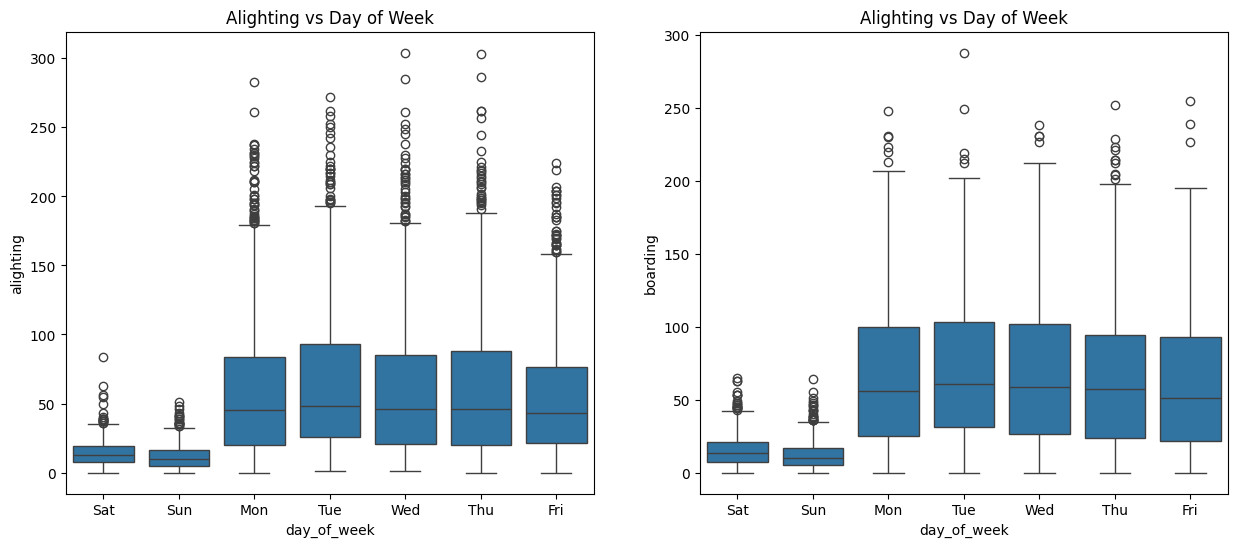

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.boxplot(capmetro_UT, x='day_of_week', y='alighting', ax=axes[0])
axes[0].set_title("Alighting vs Day of Week")
sns.boxplot(capmetro_UT, x='day_of_week', y='boarding', ax=axes[1])
axes[1].set_title("Alighting vs Day of Week")

### Conclusion

Firstly, a strange question- is there is a trend between temperature and the number of people that board or get off a bus? Are people using buses as a way to escape the heat? The answer appears to be overwhelmingly that there is no such relationship. 

We can see that in general, there was the clearest relationship between the day of week and the number of people that boarded or alighted. Specifically, if it was a weekday, more people alighted or boarded compared to on the weekends. Clearly, this must be due to the number of people having to go to work by bus. If people want to take the bus, it is likely due to high costs of living making it more convenient to take a bus. Generally, most activity in Austin takes place in the weekday, meaning the number of people using the bus should be higher than on the weekend. Furthermore, the number of people that board and get off is fairly consistent across the weekdays and weekends, suggesting that CapMetro has a loyal customer base.

Interestingly, more people boarded than alighted across the three months, suggesting that there could be overcrowding issues and buses often having a full load. This could mean that CapMetro is doing financially well.

## **Clustering and dimensionality reduction**

The data in wine.csv contains information on 11 chemical properties of 6500 different bottles of vinho verde wine from northern Portugal. In addition, two other variables about each wine are recorded:

- whether the wine is red or white
- the quality of the wine, as judged on a 1-10 scale by a panel of certified wine snobs.

Run PCA, tSNE, and any clustering algorithm of your choice on the 11 chemical properties (or suitable transformations thereof) and summarize your results. Which dimensionality reduction technique makes the most sense to you for this data? Convince yourself (and me) that your chosen approach is easily capable of distinguishing the reds from the whites, using only the "unsupervised" information contained in the data on chemical properties. Does your unsupervised technique also seem capable of distinguishing the higher from the lower quality wines? Present appropriate numerical and/or visual evidence to support your conclusions.

To clarify: I'm not asking you to run a supervised learning algorithms. Rather, I'm asking you to see whether the differences in the labels (red/white and quality score) emerge naturally from applying an unsupervised technique to the chemical properties. This should be straightforward to assess using plots.

In [32]:
wine = pd.read_csv('wine.csv')
wine_copy = wine.copy()

# Standardize certain columns
vars_to_standardize = list(wine_copy.columns.values)[:-2]

# Create a scaler object
scaler = StandardScaler()

# Fit and transform the data
wine_copy[vars_to_standardize] = scaler.fit_transform(wine_copy[vars_to_standardize])
wine_copy.head()

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free.sulfur.dioxide  total.sulfur.dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694 -0.363868   0.327510   
4            -1.100140             -1.446359  1.034993  1.813090   0.193097   

    alcohol  quality color  
0 -0.915464        5   red  
1 -0.580068        5   red  
2 -0.580068        5   red  
3 -0.580068        6   red  
4 -0.915464        5   red

### Principal Components Analysis

In [33]:
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine_copy[vars_to_standardize])

Text(0.5, 1.0, 'Quality Clustering(PCA)')

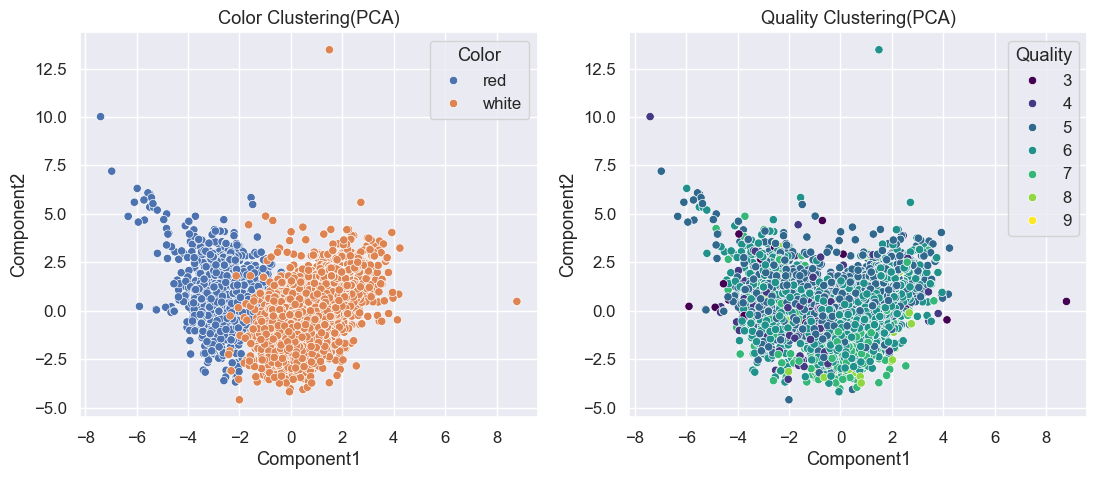

In [34]:
# convert the PCA results to a DataFrame
pca_df = pd.DataFrame(data = wine_pca, columns = ['Component1', 'Component2'])

# add the color, score names to this DataFrame
pca_df['Color'] = wine_copy['color'].values
pca_df['Quality'] = wine_copy['quality'].values

# create plots of Color and Quality
figs, axes = plt.subplots(ncols=2, figsize=(13,5))
sns.scatterplot(data=pca_df, x='Component1', y='Component2', hue='Color', ax=axes[0])
sns.scatterplot(data=pca_df, x='Component1', palette='viridis', y='Component2', hue='Quality', ax=axes[1])
axes[0].set_title('Color Clustering(PCA)')
axes[1].set_title('Quality Clustering(PCA)')

### t-SNE

In [35]:
# specify the hyperparameters. For example, we can start with a perplexity of 30 
# and a learning rate (also called epsilon) of 200. These are common starting values for tSNE.
tsne = TSNE(n_components=2, verbose=1, perplexity=50, max_iter=1000, learning_rate=300)

# run t-SNE on the standardized data
tsne_results = tsne.fit_transform(wine_copy[vars_to_standardize])
tsne_results

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6497 samples in 0.104s...
[t-SNE] Computed neighbors for 6497 samples in 0.870s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6497
[t-SNE] Computed conditional probabilities for sample 2000 / 6497
[t-SNE] Computed conditional probabilities for sample 3000 / 6497
[t-SNE] Computed conditional probabilities for sample 4000 / 6497
[t-SNE] Computed conditional probabilities for sample 5000 / 6497
[t-SNE] Computed conditional probabilities for sample 6000 / 6497
[t-SNE] Computed conditional probabilities for sample 6497 / 6497
[t-SNE] Mean sigma: 0.762605
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.748940
[t-SNE] KL divergence after 1000 iterations: 1.382779


array([[-75.54362  ,  -4.465595 ],
       [-78.29756  ,   6.6651545],
       [-77.532555 ,   6.9727983],
       ...,
       [ -3.747951 ,  14.061567 ],
       [ -5.9899387, -76.63213  ],
       [ -2.0137966, -68.543175 ]], dtype=float32)

Text(0.5, 1.0, 'Quality Clustering(tSNE)')

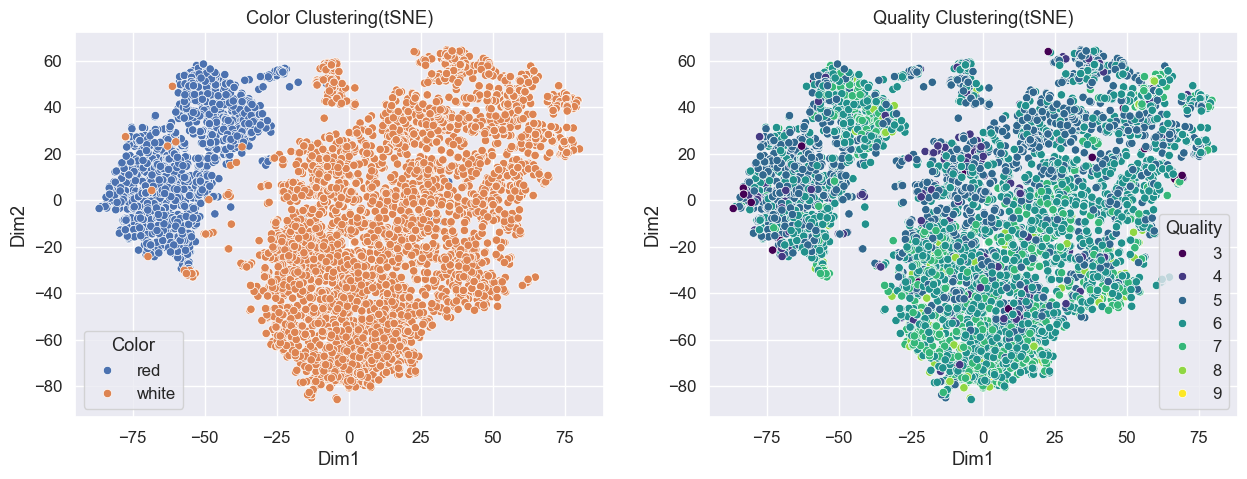

In [36]:
# convert the t-SNE results to a DataFrame
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Dim1', 'Dim2'])

# add the color, quality names to this DataFrame
tsne_df['Color'] = wine_copy['color'].values
tsne_df['Quality'] = wine_copy['quality'].values

# create side by side plots
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Color', ax=axes[0])
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', palette='viridis', hue='Quality', ax=axes[1])
axes[0].set_title('Color Clustering(tSNE)')
axes[1].set_title('Quality Clustering(tSNE)')

### K-means Clustering with PCA vs K-means Clustering with tSNE

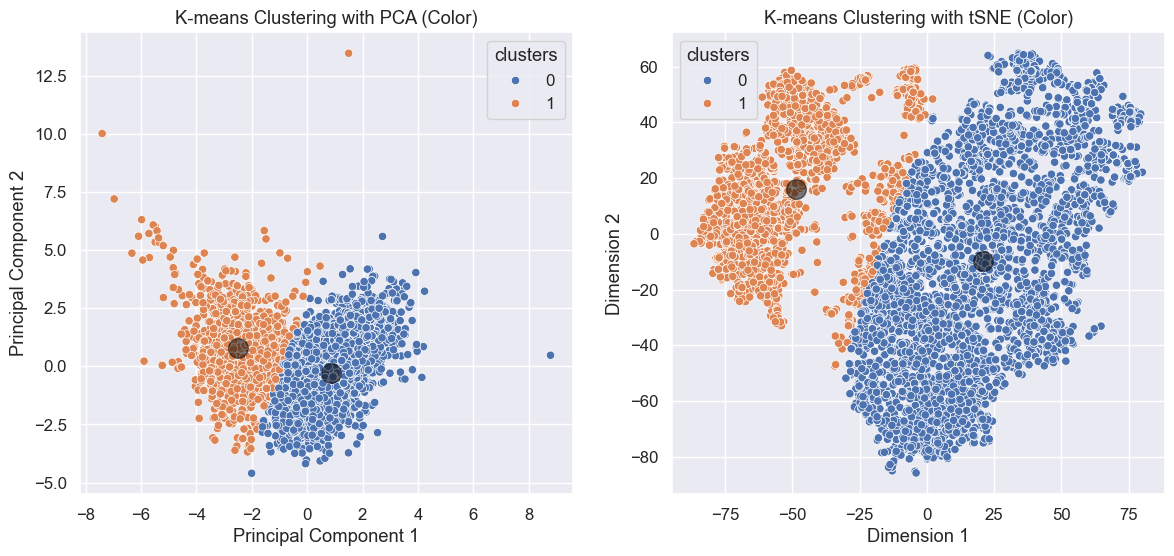

In [37]:
# K-means with PCA
kmeans = KMeans(n_clusters=2, random_state=83)
kmeans_results = kmeans.fit(wine_pca)

# Predict the labels of clusters
labels = kmeans_results.fit_predict(wine_pca)

df = pd.DataFrame(wine_pca, columns=['Principal Component 1', 'Principal Component 2'])
df['clusters'] = labels

# Get the centers
centers = kmeans_results.cluster_centers_

# Plot with two principal components
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue='clusters', data=df, ax=axes[0])

axes[0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
axes[0].set_title('K-means Clustering with PCA (Color)')

# K-means with tSNE
kmeans_tsne = kmeans.fit(tsne_results)
labels_tsne = kmeans_tsne.fit_predict(tsne_results)

df = pd.DataFrame(labels_tsne)
df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
df['clusters'] = labels_tsne
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue='clusters', data=df)

# Get the centers
centers = kmeans_results.cluster_centers_

# Plot with two dimensions
axes[1].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
axes[1].set_title('K-means Clustering with tSNE (Color)')

plt.show()

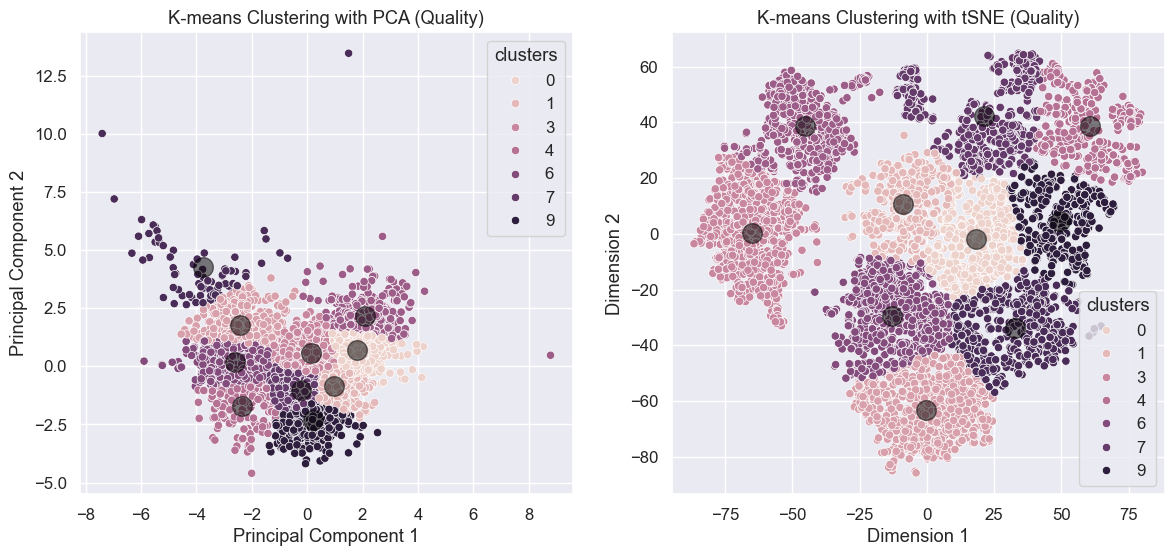

In [38]:
# K-means with PCA
kmeans = KMeans(n_clusters=10, random_state=83)
kmeans_results = kmeans.fit(wine_pca)

# Predict the labels of clusters
labels = kmeans_results.fit_predict(wine_pca)

df = pd.DataFrame(wine_pca, columns=['Principal Component 1', 'Principal Component 2'])
df['clusters'] = labels

# Get the centers
centers = kmeans_results.cluster_centers_

# Plot with two principal components
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue='clusters', data=df, ax=axes[0])

axes[0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
axes[0].set_title('K-means Clustering with PCA (Quality)')

# K-means with tSNE
kmeans_tsne = kmeans.fit(tsne_results)
labels_tsne = kmeans_tsne.fit_predict(tsne_results)

df = pd.DataFrame(labels_tsne)
df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
df['clusters'] = labels_tsne
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue='clusters', data=df)

# Get the centers
centers = kmeans_results.cluster_centers_

# Plot with two dimensions
axes[1].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
axes[1].set_title('K-means Clustering with tSNE (Quality)')

plt.show()

### Spectral Clustering with PCA and tSNE

Distinguishing quality labels

In [39]:
# Spectral Clustering with PCA
n_clusters = 10
specClustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10, random_state=42)
specClustering_results = specClustering.fit(wine_pca)

d:\UT Austin Courses\STA S380\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\UT Austin Courses\STA S380\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


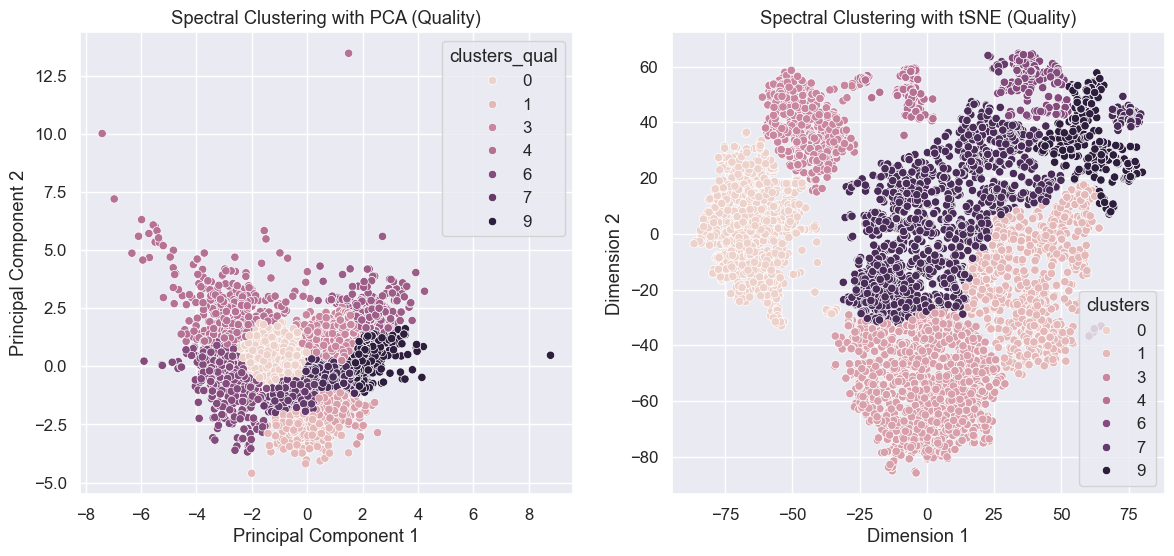

In [44]:
# Predict the labels of clusters
labels = specClustering_results.fit_predict(wine_pca)

df = pd.DataFrame(wine_pca, columns=['Principal Component 1', 'Principal Component 2'])
df['clusters_qual'] = labels

# Plot with two principal components
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue='clusters_qual', data=df, ax=axes[0])
axes[0].set_title('Spectral Clustering with PCA (Quality)')

# Spectral Clustering with tSNE
specClustering_tsne = specClustering.fit(tsne_results)
labels_tsne = specClustering_tsne.fit_predict(tsne_results)

df = pd.DataFrame(labels_tsne)
df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
df['clusters'] = labels_tsne
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue='clusters', data=df)

# Plot with two dimensions
axes[1].set_title('Spectral Clustering with tSNE (Quality)')

plt.show()

### Conclusion

First, we run tSNE and PCA dimension reduction methods, reducing to two dimensions and then plotting a graph of these two dimensions. The initial results show that there are more distinguishable clusters when running tSNE. 

When running K-means on both sets of dimension reduced data, the plots show that the clustering algorithm had similar conclusions to the plots generated with dimension reduction methods with labels applied to the data. The clustering method was able to distinguish two distinct clusters with reasonable accuracy and thus did a good job of determining the wine color based off the cluster. Of course, even though K-means is among the most simple of clustering methods, the dimension reduced plots already showed evidence of potential clustering. For wine color, there were two distinct and clear clusters that formed out of the data. As a result, since K-means is good at detecting these types of shapes, it did quite well. Compared to other clustering methods, it is also very fast and since it performs the task well, it is a good choice for a clustering algorithm. Between the two dimension reduced methods, it makes sense to use PCA and then K-means based off comparisons with where the true labels were clustered.

However, it is a different story when it comes to clustering on quality. After applying dimension reduction methods on the dataset, it was clear that there were no clear clusters when it comes to quality. The K-means clustering algorithm tried to separate the points into distinct clusters when there were no clear signs of clustering in the first place. Even when using spectral clustering, it attempted to separate quality into distinct clusters rather than seeing the intricate nature of the groups.

## **Market Segmentation**

Consider the data in social_marketing.csv. This was data collected in the course of a market-research study using followers of the Twitter account of a large consumer brand that shall remain nameless---let's call it "NutrientH20" just to have a label. The goal here was for NutrientH20 to understand its social-media audience a little bit better, so that it could hone its messaging a little more sharply.

A bit of background on the data collection: the advertising firm who runs NutrientH20's online-advertising campaigns took a sample of the brand's Twitter followers. They collected every Twitter post ("tweet") by each of those followers over a seven-day period in June 2014. Every post was examined by a human annotator contracted through Amazon's Mechanical Turk service. Each tweet was categorized based on its content using a pre-specified scheme of 36 different categories, each representing a broad area of interest (e.g. politics, sports, family, etc.) Annotators were allowed to classify a post as belonging to more than one category. For example, a hypothetical post such as "I'm really excited to see grandpa go wreck shop in his geriatic soccer league this Sunday!" might be categorized as both "family" and "sports." You get the picture.

Each row of social_marketing.csv represents one user, labeled by a random (anonymous, unique) 9-digit alphanumeric code. Each column represents an interest, which are labeled along the top of the data file. The entries are the number of posts by a given user that fell into the given category. Two interests of note here are "spam" (i.e. unsolicited advertising) and "adult" (posts that are pornographic, salacious, or explicitly sexual). There are a lot of spam and pornography "bots" on Twitter; while these have been filtered out of the data set to some extent, there will certainly be some that slip through. There's also an "uncategorized" label. Annotators were told to use this sparingly, but it's there to capture posts that don't fit at all into any of the listed interest categories. (A lot of annotators may used the "chatter" category for this as well.) Keep in mind as you examine the data that you cannot expect perfect annotations of all posts. Some annotators might have simply been asleep at the wheel some, or even all, of the time! Thus there is some inevitable error and noisiness in the annotation process.

Your task to is analyze this data as you see fit, and to prepare a concise report for NutrientH20 that identifies any interesting market segments that appear to stand out in their social-media audience. You have complete freedom in deciding how to pre-process the data and how to define "market segment." (Is it a group of correlated interests? A cluster? A latent factor? Etc.) Just use the data to come up with some interesting, well-supported insights about the audience, and be clear about what you did.

In [73]:
pd.set_option('display.max_columns', None)
social_marketing = pd.read_csv('social_marketing.csv')
social_marketing = social_marketing.rename(columns={'Unnamed: 0': 'UserId'}).set_index('UserId')
social_marketing_copy = social_marketing.copy()
social_marketing_copy.shape

(7882, 36)

Ideally, from our data, we want to find clusters of distinct users based on the topics they tweet about. To properly analyze the data in a organized fashion, it would be helpful to apply a dimension reduction method since there are 36 different features. Theoretically, it is possible to analyze multiple pair wise features, but it would take much longer. 

### PCA Dimension Reduction

On the entire dataset, there are a large number of features and it is difficult to look at the relationships between each feature and find a noticeable cluster. That motivates us to employ PCA to determine the optimal reduced number of dimensions that captures most of the information. 

First, we must determine the best number of components to use.

In [97]:
# Standardize certain columns, create a scaler object
scaler = StandardScaler()

# Fit and transform the data
vars_to_standardize = social_marketing_copy.columns.values
social_marketing_copy[vars_to_standardize] = scaler.fit_transform(social_marketing_copy[vars_to_standardize])

# Test on the number of principal components
explained_var_ratios = []
for ncomps in range(1, social_marketing_copy.shape[1]):
    pca = PCA(n_components=ncomps)
    social_marketing_pca_comps = pca.fit(social_marketing_copy)
    explained_var_ratios.append((ncomps, sum(social_marketing_pca_comps.explained_variance_ratio_)))

explained_var_ratios[10:]

[(11, 0.6358029076149107),
 (12, 0.6618233051216501),
 (13, 0.6874930847597619),
 (14, 0.7122497268895528),
 (15, 0.7364283656180735),
 (16, 0.7597854837689177),
 (17, 0.7823866801889182),
 (18, 0.8028684209589191),
 (19, 0.8222198842499319),
 (20, 0.8402401638494479),
 (21, 0.8559948890544542),
 (22, 0.8694632136024985),
 (23, 0.8825194915052401),
 (24, 0.8943704261827449),
 (25, 0.9060634825187127),
 (26, 0.9173545632402619),
 (27, 0.9285996644001718),
 (28, 0.939110507939488),
 (29, 0.9491662883784436),
 (30, 0.9589752748144745),
 (31, 0.9685411723142698),
 (32, 0.9769367874404286),
 (33, 0.9834553094324502),
 (34, 0.9897428394421057),
 (35, 0.9950613637055751)]

It looks like we would need a fairly large number of principal components to capture most of the variance. However, it would suffice to try `n_components = 18` as it captures roughly $80\%$ of the explained variance while keeping the dimensionality of our data decently low.

In [108]:
# Applying PCA with n_components = 18
pca = PCA(n_components=18)
social_marketing_pca = pca.fit(social_marketing_copy)

# Have the PC's placed in a dataframe
colnames = ['PC{}'.format(i) for i in range(1, 19)]
PCA_18 = pd.DataFrame(social_marketing_pca.components_.T, columns=colnames)
PCA_18['Features'] = social_marketing_pca.feature_names_in_
PCA_18 = PCA_18.set_index('Features')

Now we do a glance at some of the principal components to see what information it is trying to tell us. We pick out some of the components with the most identifiable choices of feature weights.

In [118]:
# PC 1
pca1 = PCA_18[['PC1']].sort_values(by='PC1', ascending=False)
pca1.T # Could be representing the most mainstream of topics (an average person tweeting)

Features  religion     food  parenting  sports_fandom    school    family  \
PC1         0.2971  0.29691   0.294004       0.287732  0.280638  0.244269   

Features    beauty    crafts   cooking   fashion  photo_sharing       eco  \
PC1       0.201518  0.193628  0.188809  0.183882        0.18028  0.145336   

Features  computers  outdoors  personal_fitness  business  shopping  \
PC1        0.143331  0.142604          0.137501   0.13501  0.132995   

Features  automotive  politics  sports_playing      news   chatter  \
PC1         0.131325  0.130266        0.130217  0.127643  0.125992   

Features  health_nutrition     music  small_business    travel  \
PC1               0.124201  0.124089        0.119042  0.116649   

Features  home_and_garden    dating       art   tv_film  current_events  \
PC1              0.115765  0.105156  0.097949  0.097457        0.097237   

Features  uncategorized  college_uni  online_gaming     adult      spam  
PC1            0.094435     0.094157        0.07389  0.026731  0.011461

In [132]:
# PC 2
pca2 = PCA_18[['PC2']].sort_values(by='PC2', ascending=False)
pca2.T # Could be representing tweeters who are outspoken with sports and religion and not interested with cooking, photos(males?)

Features  sports_fandom  religion  parenting      food    school    family  \
PC2            0.316924  0.316153   0.295082  0.237809  0.197572  0.196253   

Features      news  automotive    crafts     adult      spam  politics  \
PC2       0.036199    0.031564  0.021623  0.006918  0.004552  -0.01394   

Features  computers    travel  home_and_garden       art  current_events  \
PC2       -0.037335 -0.039947        -0.046803 -0.060347       -0.064036   

Features    dating   tv_film  online_gaming       eco  small_business  \
PC2      -0.071535 -0.079353      -0.083592 -0.085322       -0.094048   

Features  business  sports_playing  outdoors  college_uni    music  \
PC2      -0.098783       -0.108595 -0.113582     -0.11596 -0.14426   

Features  personal_fitness  uncategorized  health_nutrition   chatter  \
PC2              -0.144612      -0.146499         -0.146578 -0.197226   

Features   beauty  shopping  fashion  photo_sharing   cooking  
PC2      -0.20861 -0.209853  -0.2798      -0.303078 -0.314288

In [114]:
# PC 3
pca3 = PCA_18[['PC3']].sort_values(by='PC3', ascending=False)
pca3.T # Could be representing the more professional types of tweeters concerned more about business with no regard for health

Features  politics   travel  computers      news  automotive  business  \
PC3       0.489903  0.42426   0.367031  0.336036    0.190843  0.105175   

Features  small_business  tv_film  college_uni   chatter  online_gaming  \
PC3             0.100597  0.08621     0.085412  0.074807       0.055108   

Features  current_events       art  shopping  sports_playing    dating  \
PC3              0.05224  0.049892  0.047223        0.042595  0.031346   

Features  home_and_garden      spam    crafts     adult  photo_sharing  \
PC3              0.021179  0.012631  0.002365 -0.002867       -0.01071   

Features     music      eco  uncategorized    family  sports_fandom    school  \
PC3      -0.012288 -0.02945      -0.030542 -0.049318      -0.051997 -0.081644   

Features  parenting  religion      food   fashion  outdoors   beauty  cooking  \
PC3       -0.089166 -0.093129 -0.111477 -0.138769  -0.14039 -0.15071  -0.1945   

Features  personal_fitness  health_nutrition  
PC3              -0.217375         -0.225515

In [120]:
# PC 5
pca5 = PCA_18[['PC5']].sort_values(by='PC5', ascending=False)
pca5.T # Could be representing what college students do during their school life to blow off steam

Features  college_uni  online_gaming  sports_playing   tv_film  \
PC5          0.487018       0.476423        0.370646  0.210238   

Features  health_nutrition       art  personal_fitness  outdoors     music  \
PC5                0.16716  0.164086          0.156624  0.147172  0.066195   

Features      food  uncategorized  home_and_garden    crafts  small_business  \
PC5       0.066129       0.061021         0.037974  0.036923        0.033157   

Features      spam       eco     adult    travel   dating    family  religion  \
PC5       0.019733  0.015959  0.011412 -0.007837 -0.01033 -0.010782 -0.021732   

Features      news  sports_fandom  parenting  business  automotive  computers  \
PC5      -0.025065       -0.03279  -0.041676 -0.051828   -0.057408  -0.057677   

Features  politics  current_events    school   cooking   fashion    beauty  \
PC5      -0.057945        -0.05819 -0.089432 -0.122522 -0.171197 -0.185948   

Features   chatter  shopping  photo_sharing  
PC5      -0.192782 -0.197454      -0.229661

In [121]:
# PC 7
pca7 = PCA_18[['PC7']].sort_values(by='PC7', ascending=False)
pca7.T # Could be representing more artistic people who enjoy "cultured" art as opposed to gaming

Features   tv_film       art    crafts  small_business  uncategorized  \
PC7       0.504764  0.488546  0.237881        0.210345       0.187378   

Features    music  home_and_garden  business    travel    adult      spam  \
PC7       0.14774         0.093926  0.088003  0.085039  0.06958  0.066753   

Features  current_events     food    dating  religion    school       eco  \
PC7             0.037305  0.03609  0.029061  0.022604  0.021134  0.001924   

Features  computers   beauty   fashion  parenting  health_nutrition  \
PC7       -0.010522 -0.02071 -0.029706  -0.035499         -0.038618   

Features  personal_fitness   cooking  outdoors  politics  sports_fandom  \
PC7              -0.043272 -0.058196 -0.061131 -0.065212      -0.068625   

Features  shopping    family   chatter  photo_sharing     news  college_uni  \
PC7      -0.086096 -0.100158 -0.107731      -0.126507 -0.14371    -0.185409   

Features  sports_playing  automotive  online_gaming  
PC7            -0.218616   -0.241192      -0.288078

In [258]:
# PC 8
pca8 = PCA_18[['PC8']].sort_values(by='PC8', ascending=False)
pca8.T # Could be representing people who are interested in cars and the news and conversely not as interested in computers

Features  automotive      news   tv_film       art  sports_fandom  \
PC8         0.585624  0.462843  0.220042  0.164651       0.109529   

Features  home_and_garden     music  outdoors    beauty  current_events  \
PC8              0.098751  0.088925  0.076146  0.062075        0.054642   

Features   cooking  uncategorized    family   fashion    adult      spam  \
PC8       0.049914       0.049087  0.022148  0.019832 -0.00443 -0.011806   

Features  small_business  politics  photo_sharing    crafts  shopping  \
PC8            -0.013161 -0.014884      -0.022201 -0.028324 -0.033798   

Features  personal_fitness  health_nutrition  college_uni       eco  \
PC8              -0.036799          -0.03688    -0.042587 -0.043334   

Features  online_gaming  parenting  sports_playing  chatter    school  \
PC8           -0.060658  -0.060895       -0.064218 -0.07086 -0.078285   

Features      food  religion  business    dating    travel  computers  
PC8      -0.089833 -0.101704  -0.13751 -0.165901 -0.306906  -0.357937

In [173]:
# PC 9
pca9 = PCA_18[['PC9']].sort_values(by='PC9', ascending=False)
pca9.T # Could be representing the spammers

Features     adult     spam  small_business       eco  home_and_garden  \
PC9       0.688791  0.65885        0.115087  0.081416         0.080543   

Features  automotive    dating  uncategorized  online_gaming  outdoors  \
PC9         0.056602  0.053935       0.053613       0.041664  0.026528   

Features    school   fashion  current_events    beauty   chatter  parenting  \
PC9       0.026253  0.023488        0.019799  0.017833  0.016337   0.010367   

Features  computers  college_uni    family   cooking  sports_playing  \
PC9        0.007744     0.005086 -0.001777 -0.003778       -0.005778   

Features      news  photo_sharing  sports_fandom    travel    crafts  \
PC9      -0.010552      -0.016314      -0.018173 -0.019255 -0.025548   

Features  religion  politics  personal_fitness  shopping     food       art  \
PC9      -0.032114 -0.034577         -0.042785 -0.049167 -0.05367 -0.054174   

Features  health_nutrition     music  business   tv_film  
PC9              -0.055243 -0.072913 -0.111178 -0.128393

In [211]:
# PC 10
pca10 = PCA_18[['PC10']].sort_values(by='PC10', ascending=False)
pca10.T # Could be representing tweeters interested in dating

Features    dating  uncategorized  home_and_garden    school   chatter  \
PC10      0.755751       0.266975         0.266186  0.247171  0.107072   

Features      news  automotive  business  sports_playing    crafts   fashion  \
PC10      0.081177    0.075053  0.069704        0.067964  0.040801  0.040075   

Features  outdoors  small_business  online_gaming  sports_fandom  \
PC10      0.020254       -0.003947      -0.010375      -0.028174   

Features  personal_fitness  health_nutrition  politics       art    beauty  \
PC10             -0.028807         -0.031793 -0.035456 -0.036082 -0.037575   

Features  parenting  college_uni     adult  religion  tv_film    family  \
PC10      -0.040487    -0.042147 -0.058855 -0.065556 -0.09574 -0.100266   

Features  computers      food    travel   cooking  current_events       eco  \
PC10      -0.102962 -0.103468 -0.105952 -0.111273       -0.112115 -0.114197   

Features      spam  shopping  photo_sharing     music  
PC10     -0.116178 -0.128364      -0.131304 -0.184136

In [157]:
# PC 11
pca11 = PCA_18[['PC11']].sort_values(by='PC11', ascending=False)
pca11.T # Could be representing music vs art tweeters (+Music, -Art)

Features     music  uncategorized  business  small_business  outdoors  \
PC11      0.691636       0.358769  0.116263        0.111589  0.075572   

Features  religion  sports_fandom  college_uni  tv_film  parenting     adult  \
PC11      0.067793       0.061171     0.050471  0.04272   0.029866  0.027291   

Features  current_events    dating  computers      food  automotive   school  \
PC11            0.026388  0.018079   0.017571  0.006947    0.002988  0.00096   

Features      spam   chatter    travel  politics  sports_playing      news  \
PC11     -0.003158 -0.004702 -0.013254 -0.016145       -0.020039 -0.022573   

Features  health_nutrition  personal_fitness  shopping    family    beauty  \
PC11             -0.029088         -0.029898 -0.042186 -0.047668 -0.051791   

Features  home_and_garden       eco  photo_sharing   cooking   fashion  \
PC11            -0.052871 -0.077098      -0.080058 -0.094494 -0.098763   

Features  online_gaming    crafts       art  
PC11          -0.143531 -0.306951 -0.432437

In [194]:
# PC 18
pca18 = PCA_18[['PC18']].sort_values(by='PC18', ascending=False)
pca18.T # Could be representing that crafts usually doesn't have much spam

Features    crafts     adult      eco  business  home_and_garden  \
PC18      0.637148  0.324165  0.20388  0.149226         0.130524   

Features  small_business     music  current_events   family  automotive  \
PC18            0.111876  0.091021         0.05142  0.04389    0.043107   

Features  uncategorized  online_gaming    beauty      news  outdoors  \
PC18           0.031882       0.023979  0.011982  0.007365 -0.004382   

Features  college_uni  computers   cooking  sports_playing   fashion  \
PC18        -0.006598  -0.007267 -0.015597        -0.02065 -0.024625   

Features  politics  religion  parenting  sports_fandom    travel  \
PC18     -0.037977 -0.041709  -0.046709      -0.050233 -0.054279   

Features  personal_fitness  health_nutrition  photo_sharing      food  \
PC18             -0.055341         -0.061775      -0.072068 -0.087945   

Features  shopping   chatter    dating    school   tv_film      art      spam  
PC18     -0.107921 -0.112869 -0.122558 -0.145972 -0.210011 -0.25134 -0.423138

Now that we have some interesting principal components, we can then plot them to see if there are any potential clustering characteristics.

In [140]:
# Get the results into a dataframe
social_marketing_pca_vals = pca.fit_transform(social_marketing_copy)
social_marketing_pca_df = pd.DataFrame(social_marketing_pca_vals, columns=colnames)

Text(0.5, 1.0, 'PC18 vs PC9')

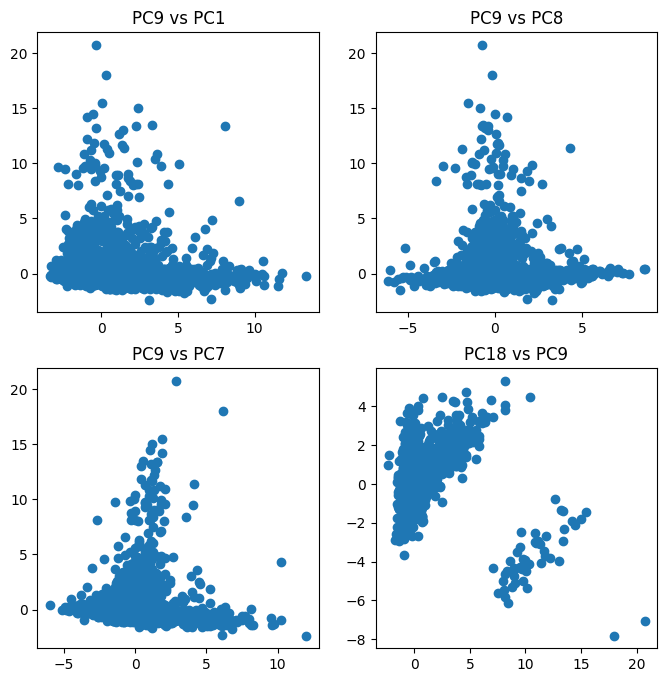

In [259]:
# Do a few plots and see if there are clustering properties 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0][0].scatter(social_marketing_pca_df['PC1'], social_marketing_pca_df['PC9'])
axes[0][0].set_title("PC9 vs PC1")
axes[0][1].scatter(social_marketing_pca_df['PC8'], social_marketing_pca_df['PC9'])
axes[0][1].set_title("PC9 vs PC8")
axes[1][0].scatter(social_marketing_pca_df['PC7'], social_marketing_pca_df['PC9'])
axes[1][0].set_title("PC9 vs PC7")
axes[1][1].scatter(social_marketing_pca_df['PC9'], social_marketing_pca_df['PC18'])
axes[1][1].set_title("PC18 vs PC9")

### K-Means Clustering + Spectral Clustering

In [225]:
# Apply K-Means first
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters) # Start with 2 clusters
kmeans_results = kmeans.fit(social_marketing_pca_vals)
kmeans_labels = kmeans_results.fit_predict(social_marketing_pca_vals)
df = pd.DataFrame(social_marketing_pca_vals, columns=colnames)
df['clusters'] = kmeans_labels

# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', 
                                         n_neighbors=10, random_state=42)
spectral_labels = spectral_clustering.fit_predict(social_marketing_pca_vals)

We start with an analysis of PC18 vs PC9. We then also take a look at PC7 vs PC9.

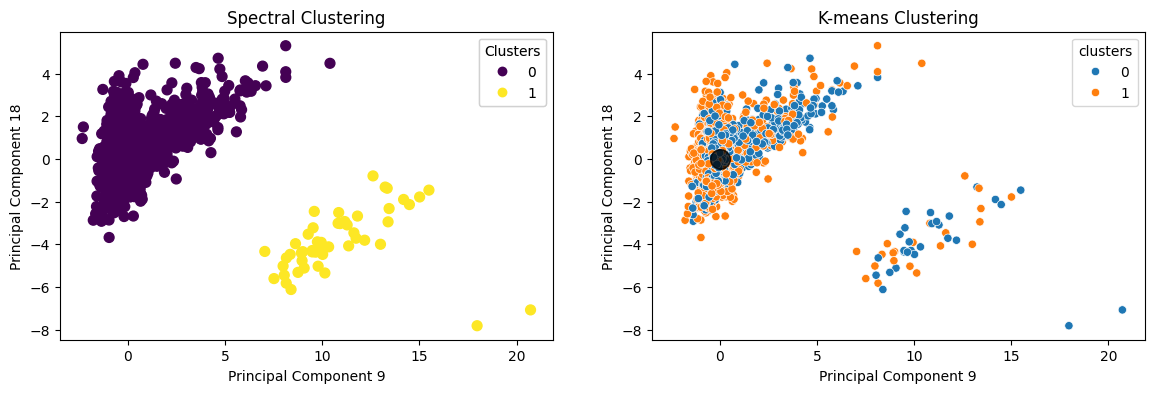

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot Spectral Clustering
scatter1 = axes[0].scatter(social_marketing_pca_vals[:, 8], 
                           social_marketing_pca_vals[:, 17], 
                           c=spectral_labels, cmap='viridis', marker='o', s=50)
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Clusters")
axes[0].add_artist(legend1)
axes[0].set_title("Spectral Clustering")
axes[0].set_xlabel("Principal Component 9")
axes[0].set_ylabel("Principal Component 18")

# Plot K-means with two principal components
sns.scatterplot(x="PC9", y="PC18", hue='clusters', data=df, ax=axes[1])

# Get the centers
centers = kmeans_results.cluster_centers_
axes[1].scatter(centers[:, 8], centers[:, 17], c='black', s=200, alpha=0.5)
axes[1].set_title('K-means Clustering')
axes[1].set_xlabel("Principal Component 9")
axes[1].set_ylabel("Principal Component 18")
plt.show()

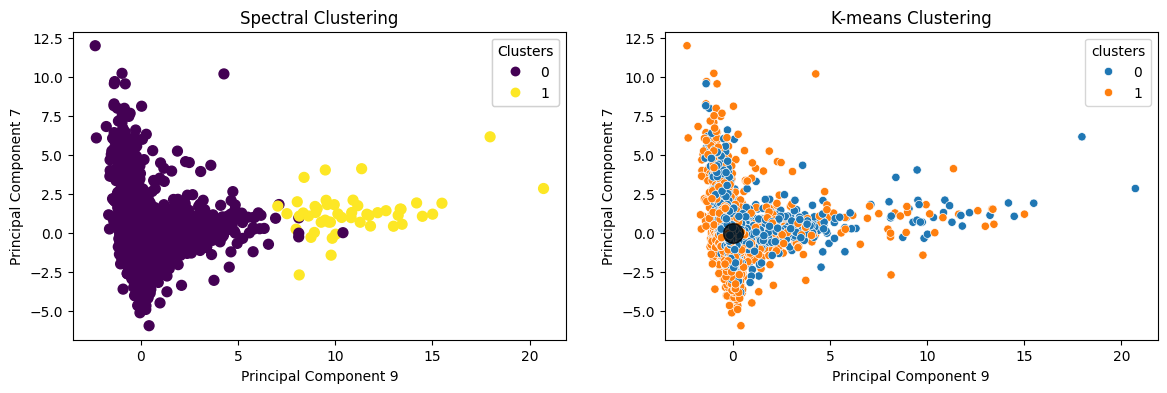

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot Spectral Clustering
scatter1 = axes[0].scatter(social_marketing_pca_vals[:, 8], 
                           social_marketing_pca_vals[:, 6], 
                           c=spectral_labels, cmap='viridis', marker='o', s=50)
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Clusters")
axes[0].add_artist(legend1)
axes[0].set_title("Spectral Clustering")
axes[0].set_xlabel("Principal Component 9")
axes[0].set_ylabel("Principal Component 7")

# Plot K-means with two principal components
sns.scatterplot(x="PC9", y="PC7", hue='clusters', data=df, ax=axes[1])

# Get the centers
centers = kmeans_results.cluster_centers_
axes[1].scatter(centers[:, 8], centers[:, 6], c='black', s=200, alpha=0.5)
axes[1].set_title('K-means Clustering')
axes[1].set_xlabel("Principal Component 9")
axes[1].set_ylabel("Principal Component 7")
plt.show()

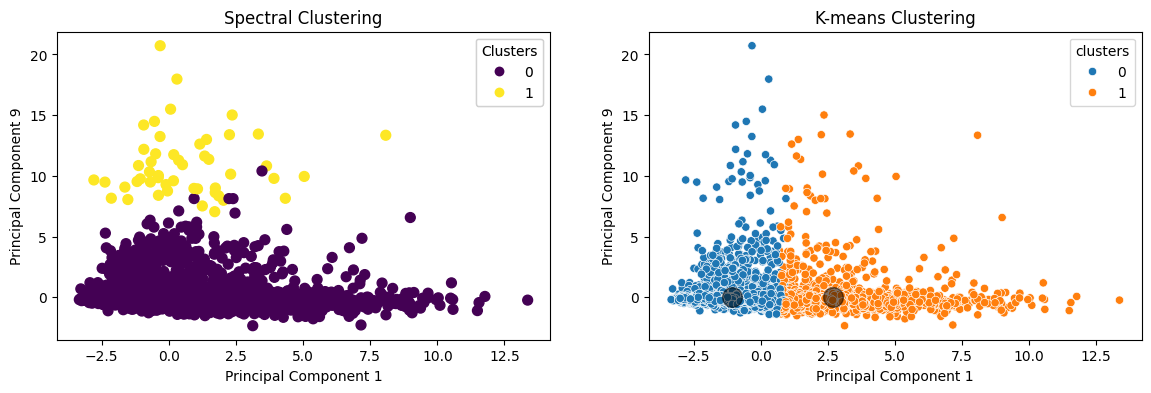

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot Spectral Clustering
scatter1 = axes[0].scatter(social_marketing_pca_vals[:, 0], 
                           social_marketing_pca_vals[:, 8], 
                           c=spectral_labels, cmap='viridis', marker='o', s=50)
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Clusters")
axes[0].add_artist(legend1)
axes[0].set_title("Spectral Clustering")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 9")

# Plot K-means with two principal components
sns.scatterplot(x="PC1", y="PC9", hue='clusters', data=df, ax=axes[1])

# Get the centers
centers = kmeans_results.cluster_centers_
axes[1].scatter(centers[:, 0], centers[:, 8], c='black', s=200, alpha=0.5)
axes[1].set_title('K-means Clustering')
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 9")
plt.show()

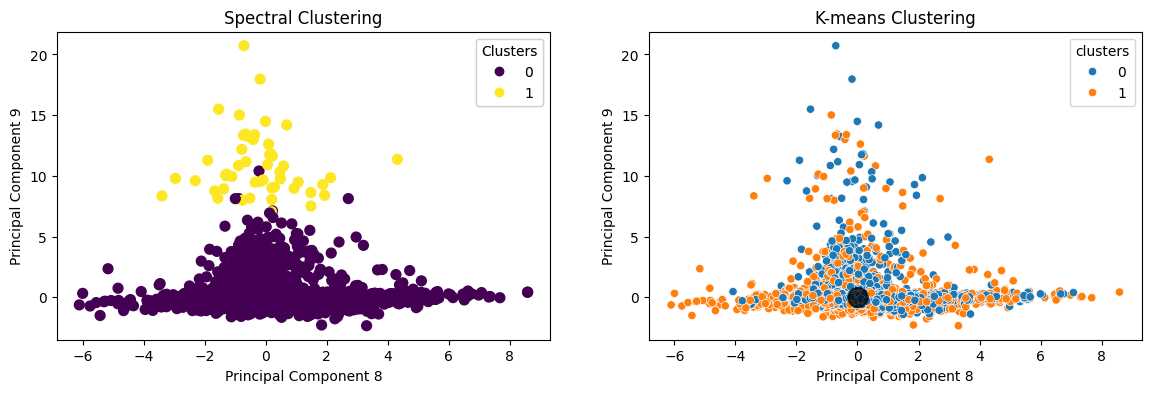

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot Spectral Clustering
scatter1 = axes[0].scatter(social_marketing_pca_vals[:, 7], 
                           social_marketing_pca_vals[:, 8], 
                           c=spectral_labels, cmap='viridis', marker='o', s=50)
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Clusters")
axes[0].add_artist(legend1)
axes[0].set_title("Spectral Clustering")
axes[0].set_xlabel("Principal Component 8")
axes[0].set_ylabel("Principal Component 9")

# Plot K-means with two principal components
sns.scatterplot(x="PC8", y="PC9", hue='clusters', data=df, ax=axes[1])

# Get the centers
centers = kmeans_results.cluster_centers_
axes[1].scatter(centers[:, 7], centers[:, 8], c='black', s=200, alpha=0.5)
axes[1].set_title('K-means Clustering')
axes[1].set_xlabel("Principal Component 8")
axes[1].set_ylabel("Principal Component 9")
plt.show()

### Report

It would be beneficial to find distinct clusters to characterize market segments. However, with a decently large number of features, it would be difficult and tedious to try and pick pairs. Thus, it makes sense to use PCA to reduce the dimensions to decrease workload, as well as being able to visualize the effects of groups of features. Afterwards, we want to find a number of distinct clusters based on the dimension reduced data. Two methods were employed: K-means and Spectral Clustering. Both methods were used as K-means is fast but has trouble with certain shapes of clusters. Spectral clustering is stronger for observing non-linear patterns in data.

We can see that Principal Component 9 is especially impactful in creating clusters. This principal component seems to be especially correlated with spammers- this component increases as the number of spam tweets increases.

When plotting principal component 18 and principal component 9 together, we can see that there are distinct clusters. The yellow cluster seems to represent genuine spammers, while the purple cluster may be people who are just interested in crafts. This seems to suggest that people who enjoy crafts have higher chances of not being spammers.

The analysis of principal component 7 and 9 seems to suggest that if people do not tweet much about art, tv and movies- mediums of entertainment that may be considered as old- they are in turn tweeting more about gaming as well. However, this seems to increase the chance that it is also spammers that are tweeting. Thus, the presence of spam seems more prevalent in gaming than it is in art, tv and movies. 

When looking at the plot of principal components 1 and 9, we see that it could suggest that if people are not tweeting as much about religion, family, sports, then it could suggest the tweeters are actually spammers.

In conclusion, many of the tweeters that are talking about computer games may be spammers, probably since gaming is such a major industry that has been heavily monetized through the proliferation of ads. Meanwhile, the tweeters who talk about religion, family, arts are more likely to be normal people and more interested in having a normal and stable life.

## **The Reuters Corpus**

Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:

- you could cluster authors or documents and tell a story about what you find.
- you could look for common factors using PCA.
- you could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
- you could do anything else that strikes you as interesting with this data.

Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:

- Question: What question(s) are you trying to answer?
- Approach: What approach/statistical tool did you use to answer the questions?
- Results: What evidence/results did your approach provide to answer the questions? (E.g. any numbers, tables, figures as appropriate.)
- Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply ignore those new words.)

### Question

Reuters is a reputable news source, and an average user would expect a level of objectivity in the articles that are written. However, this does not necessarily mean that the articles can be completely devoid of the writer's opinion. In fact, in past research articles, it has been found that gender seems to have some impact on the types of articles that are written. 

Thus, the question that this project will try to answer is foremost, is it possible to determine the gender of a reporter given the type of article written? Is there merit to research pointing to the fact that there is in fact a noticable difference in what men and women choose to write?

### Approach

To do a prediction on the gender of the writer of a document, it made sense to use a neural network since extracting the pertinent information is not clear and a model with high amount of flexibility is needed to delve deep into the particulars of the data. First, the documents were cleaned and stop words were also removed. Afterwards, to make the data easier to work with and more interpretable, the vectorized documents were then reduced to $1000$ features using principal component analysis. Finally, a neural network was trained on a training set and then used to predict the gender of the person who wrote a document in the test set.

In [3]:
# Name-to-gender dict
dict_gender = {'AaronPressman': 'male', 'AlanCrosby': 'male', 'AlexanderSmith': 'male', 'BenjaminKangLim': 'male', 'BernardHickey': 'male',
               'BradDorfman': 'male', 'DarrenSchuettler':'male', 'DavidLawder': 'male', 'EdnaFernandes': 'female', 'EricAuchard': 'male', 
               'FumikoFujisaki': 'female', 'GrahamEarnshaw': 'male', 'HeatherScoffield':'female', 'JanLopatka': 'male', 'JaneMacartney': 'female', 
               'JimGilchrist':'male',
               'JoWinterbottom': 'female', 'JoeOrtiz':'male', 'JohnMastrini': 'male', 'JonathanBirt':'male', 'KarlPenhaul': 'male',
               'KeithWeir':'male', 'KevinDrawbaugh':'male', 'KevinMorrison':'male', 'KirstinRidley':'female', 'KouroshKarimkhany': 'male',
               'LydiaZajc': 'female', 'LynneO\'Donnell': 'female', 'LynnleyBrowning': 'female', 'MarcelMichelson': 'male',
               'MarkBendeich': 'male', 'MartinWolk': 'male', 'MatthewBunce': 'male', 'MichaelConnor': 'male', 'MureDickie': 'male',
               'NickLouth': 'male', 'PatriciaCommins': 'female', 'PeterHumphrey': 'male', 'PierreTran': 'male', 'RobinSidel': 'female',
               'RogerFillion': 'male', 'SamuelPerry': 'male', 'SarahDavison': 'female', 'ScottHillis': 'male', 'SimonCowell': 'male', 'TanEeLyn': 'female',
               'TheresePoletti':'female', 'TimFarrand': 'male', 'ToddNissen': 'male', 'WilliamKazer': 'male'} 

# Read the files in a specific format

# Path to the corpus
corpus_root = 'ReutersC50'

# Path to train and test folders
train_corpus_root = f'{corpus_root}/C50train'
test_corpus_root = f'{corpus_root}/C50test'

# Create PlaintextCorpusReader instances for train and test
train_corpus = PlaintextCorpusReader(train_corpus_root, '.*\.txt')
test_corpus = PlaintextCorpusReader(test_corpus_root, '.*\.txt')

In [4]:
# Preprocess documents
def preprocess(doc):
    stop_words = set(stopwords.words('english'))
    doc = doc.lower()
    doc = re.sub(r'[^a-z]+', ' ', doc)
    words = nltk.word_tokenize(doc)
    #words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Preprocess the train data and test data together
train_fileids = train_corpus.fileids()
test_fileids = test_corpus.fileids()
fileids = train_fileids + test_fileids

# Get the author names as the category names as potential label to analyze
author_names_train = [txtname.split('/')[0] for txtname in train_fileids]
author_names_test = [txtname.split('/')[0] for txtname in test_fileids]
author_gender_train = [dict_gender[name] for name in author_names_train]
author_gender_test = [dict_gender[name] for name in author_names_test]

# Preprocess each document
documents_train = [preprocess(train_corpus.raw(fileid)) for fileid in train_fileids]
documents_test = [preprocess(test_corpus.raw(fileid)) for fileid in test_fileids]

In [5]:
# Create a dataframe of training and test data
docs_df_train = pd.DataFrame(documents_train, columns=['Processed Document'])
docs_df_train['Authors'] = author_names_train
docs_df_train['Gender'] = author_gender_train
docs_df_train['Gender Val'] = docs_df_train.apply(lambda x: 1 if x['Gender'] == 'male' else 0, axis=1)

docs_df_test = pd.DataFrame(documents_test, columns=['Processed Document'])
docs_df_test['Authors'] = author_names_test
docs_df_test['Gender'] = author_gender_test
docs_df_test['Gender Val'] = docs_df_test.apply(lambda x: 1 if x['Gender'] == 'male' else 0, axis=1)
docs_df_test.head()

Processed Document        Authors Gender  \
0  u s senators on tuesday sharply criticized a n...  AaronPressman   male   
1  two members of congress criticised the federal...  AaronPressman   male   
2  commuters stuck in traffic on the leesburg pik...  AaronPressman   male   
3  a broad coalition of corporations went to capi...  AaronPressman   male   
4  on the internet where new products come and go...  AaronPressman   male   

   Gender Val  
0           1  
1           1  
2           1  
3           1  
4           1

In [6]:
# Apply a TFIDF Vectorizer to get numerical features
tfidf = TfidfVectorizer()
train_features = tfidf.fit_transform(docs_df_train['Processed Document'])
train_features.shape

(2500, 27482)

In [7]:
# Reduce the dimensionality of the articles with PCA
pca = PCA(n_components=1000)
reuters_pca = pca.fit_transform(train_features)
pca.explained_variance_ratio_.sum()

0.8298190552481984

In [19]:
# Create the test set and send it through principal components
test_features = tfidf.fit_transform(docs_df_test['Processed Document'])
reuters_pca_test = pca.fit_transform(test_features)
reuters_pca_test.shape

(2500, 1000)

### Neural Nets

In [23]:
# Construct a PyTorch model
# there is a class called module, nn.Module, any NN model that I build, I need to define these two things, init and forward.
# if you're going to define a new class, you need a class constructor.
# side comment: I have linear regression with fancy feature engineering, you're taking 1 input and having the NN contruct 64 new features.
class SimpleNN(nn.Module):
    def __init__(self, num_features, output_features):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64) # 1000 inputs, 64 outputs
        self.layer2 = nn.ReLU() # pass through ReLU, first activation
        self.layer3 = nn.Linear(64, 32) # this layer will have 64 inputs, 64 outputs, plus biases, so 64x65 parameter right here
        self.layer4 = nn.ReLU() # second activation
        self.layer5 = nn.Linear(32, output_features) 

    def forward(self, x): # member function just has to have self as the first argument, python boilerplate stuff
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

model = SimpleNN(reuters_pca.shape[1], 2) # instantiate the model here as an instance of this new class
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # Adam, ADAgrad with momentum ... changing the learning rate over. Starting with a learning rate of 0.01.

Epoch: 1, Loss: 0.698951005935669


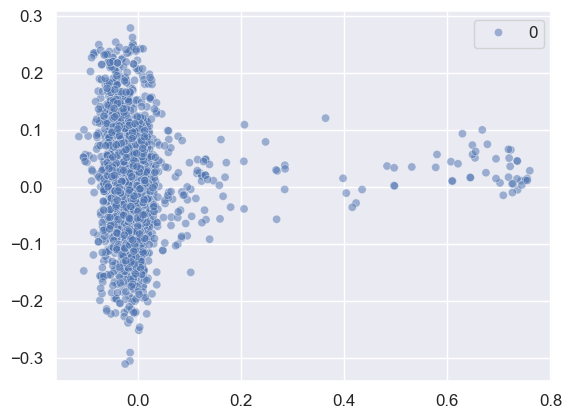

Epoch: 20, Loss: 0.10271394997835159


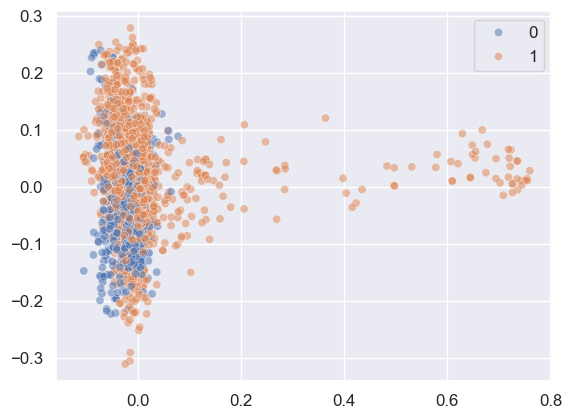

Epoch: 40, Loss: 0.0014821216464042664


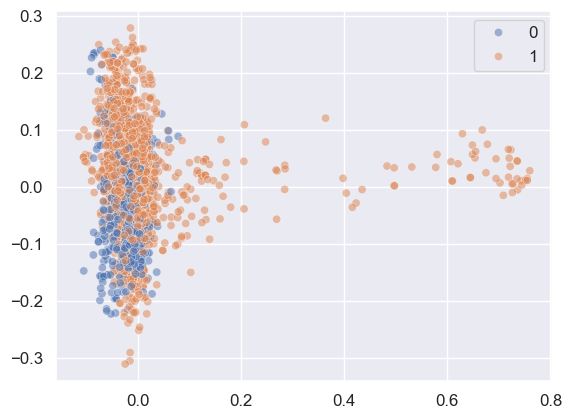

Epoch: 60, Loss: 0.0001113400430767797


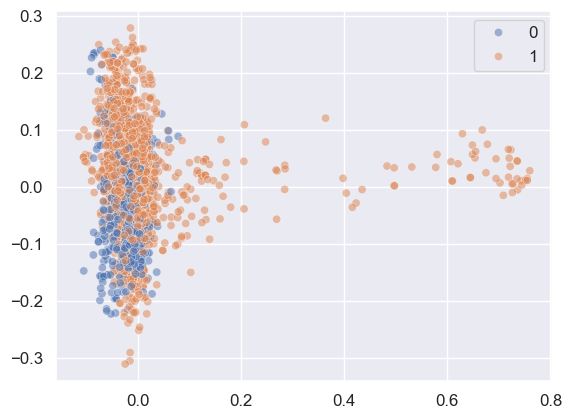

Epoch: 80, Loss: 3.33543612214271e-05


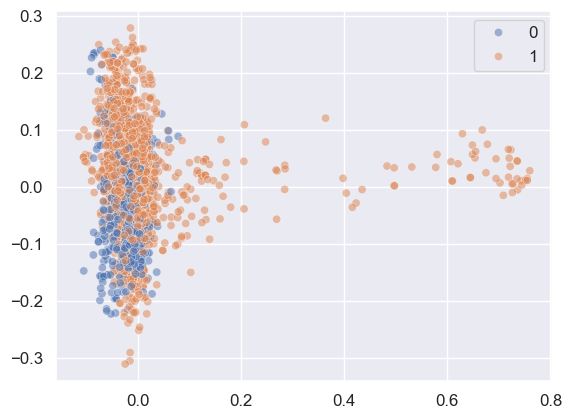

Epoch: 100, Loss: 1.9468645405140705e-05


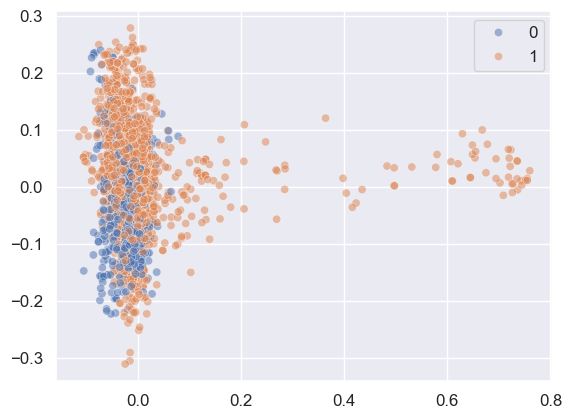

In [24]:
# Prepare the data for training
X_tensor = torch.tensor(reuters_pca.copy(), dtype=torch.float32)
y_tensor = torch.tensor(docs_df_train['Gender Val'], dtype=torch.long)

# Training
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor) 
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
        _, y_pred = torch.max(predictions, 1)
        fig, axes = plt.subplots()
        sns.scatterplot(x=reuters_pca[:, 1], y=reuters_pca[:, 2], hue=y_pred.numpy(), alpha=0.5) # Show first vs second dimension
        plt.show()

In [25]:
# Testing, evaluate
model.eval()

y_true = docs_df_test['Gender Val'].values.tolist()

all_predictions = []

with torch.no_grad():
    X_test_tensor = torch.tensor(reuters_pca_test.copy(), dtype=torch.float32)
    test_outputs = model(X_test_tensor)
    pred = torch.max(test_outputs, 1)
    all_predictions = pred

all_predictions = all_predictions.indices.tolist()
all_predictions[:5]

[1, 1, 1, 1, 1]

### Results

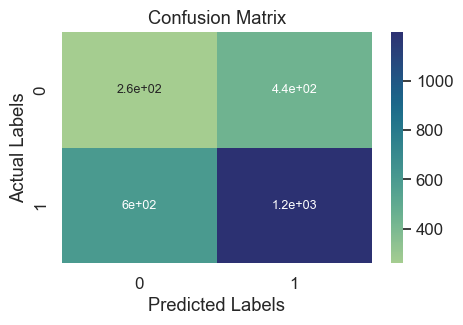

In [26]:
# Create the confusion matrix
pred_results = confusion_matrix(y_true, all_predictions)
df_preds = pd.DataFrame(pred_results)

fig, axes = plt.subplots(figsize=(5, 3))

sns.set_theme(font_scale=1.1)
sns.heatmap(df_preds, annot=True, annot_kws={"size": 9}, cmap="crest") # font size

plt.xlabel('Predicted Labels')
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Get classification scores
print(classification_report(y_true, all_predictions))

              precision    recall  f1-score   support

           0       0.30      0.37      0.33       700
           1       0.73      0.67      0.70      1800

    accuracy                           0.58      2500
   macro avg       0.52      0.52      0.51      2500
weighted avg       0.61      0.58      0.59      2500



In [28]:
accuracy_score(y_true, all_predictions)

0.5828

The results of the neural net prediction is that the overall accuracy is 60%, which is slightly better than random guessing, but clearly is not ideal. During the neural network training stage, the plots showed that it seemed to be very fast in learning and making the best predictions, yet when it came to testing, its overall accuracy was only slightly better than random guessing. Furthermore, noting that `1` was encoded for `male` and `0` for `female`, the results also show that there was a much higher precision and recall for predicting documents written by males but it was very poor for females on the other hand.

### Conclusion

In general, it does appear that there may be noticable differences in the way that women and men write their journals for Reuters. However, the predictions made by the model were solely based off the text itself - an important factor that was not included or available in the dataset was the type of story the document would be classified under. If this was included, it is likely that there may have been additional information that could have been learned by the network and thus improved the accuracy. However, the model as it is was able to do better than random guessing, suggesting that there are indeed various differences in how men and women write. Being able to accurately determine whether articles are written by a man or a woman is important for deducing any sort of biases that each gender is privy to. Understanding these biases can then in turn help improve the quality of journalism and increase its objectivity, which can only ensure the highest quality of information.

## **Association rule mining**

Revisit the notes on association rule mining and the R example on music playlists: playlists.R and playlists.csv. Then use the data on grocery purchases in groceries.txt and find some interesting association rules for these shopping baskets. The data file is a list of shopping baskets: one person's basket for each row, with multiple items per row separated by commas. Pick your own thresholds for lift and confidence; just be clear what these thresholds are and say why you picked them. Do your discovered item sets make sense? Present your discoveries in an interesting and visually appealing way.

Notes:

- This is an exercise in visual and numerical story-telling. Do be clear in your description of what you've done, but keep the focus on the data, the figures, and the insights your analysis has drawn from the data, rather than technical details.
- The data file is a list of baskets: one row per basket, with multiple items per row separated by commas. You'll have to cobble together your own code for processing this into the format expected by the "arules" package. This is not intrinsically all that hard, but it is the kind of data-wrangling wrinkle you'll encounter frequently on real problems, where your software package expects data in one format and the data comes in a different format. Figuring out how to bridge that gap is part of the assignment, and so we won't be giving tips on this front.

### Results

(Built in `Unsupervised Learning Problems.R`)

![Grocery Rules Plot with restriction on confidence and support](groceryrules.png "Grocery Rules Plot")

Notably, we can see that most of the support values are very small, indicating there was a diversity of items bought and the grocers sampled had very different tastes. 

When choosing a lift and confidence threshold, we want to make sure there are not too many rules as it would make it difficult to see any truly interesting associations. Given the plot above, there are a large number of rules and we want to reduce it down to somewhere in the magnitude of 10. 

We want the rules to be robust as it would then allow us to determine if there is a significant pattern in how people approach shopping. Thus, we first want a high confidence level. So for this problem, I set the confidence level to be greater than $60\%$, so that the pairing of items has a higher chance of happening. We also need to set a lift value greater than 1 to ensure it is better than random guessing, so we choose it to be $2.5$. 

![Grocery Rules Plot with support > 0.6, lift > 2.5](groceryrules2.png "Grocery Rules Plot")

Now we have reduced the number of rules to 9 with the restrictions we set on the apriori algorithm. From here, we can look at what the network looks like.

![Grocery Rules Network Graph](grocerygraph.png "Grocery Rules Graph")

From the network graph, it appears that the most connected nodes are the "whole milk" and "other vegetables" nodes. Interestingly, if someone buys milk, they are almost certainly going to be buying other groceries alongside this purchase. Similarly, if a person buys vegetables, then they want to include other items to their basket.

In general, the items that see to have the strongest rules are dairy items alongside fruits and vegetables, which means these are some of the most frequent items bought during a shopping trip. The network graph shows that people usually start with buying fruits and root vegetables before moving into other vegetables. People also tend to buy yogurt and other dairy products before transitioning to buy milk, likely since keeping it around in a shopping cart for a while can increase its spoiling time.

## **Image classification with neural networks**

In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

- overall test-set accuracy, measured however you think is appropriate
- show some of the example images from the test set, together with your model's predicted classes.
-ba confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

In [2]:
# Before doing anything, calculating mean and std for normalization
transform = transforms.Compose([transforms.ToTensor()])
original_set = torchvision.datasets.ImageFolder('EuroSAT_RGB', transform=transform)
n = len(original_set)

mean = torch.zeros(3)
std = torch.zeros(3)

for img, _ in original_set:
    mean += img.mean(dim=[1, 2])
    std += img.std(dim=[1,2])
    
mean /= n
std /= n

(mean, std)

(tensor([0.3444, 0.3803, 0.4078]), tensor([0.0914, 0.0651, 0.0552]))

In [3]:
# random seed set for reproducibility
random.seed(83)

# Load in the images from the directory. Also need to transform to tensor
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=mean, std=std)])
original_set = torchvision.datasets.ImageFolder('EuroSAT_RGB', transform=transform)
n = len(original_set)

# Split 80/20 training and test split
n_train = int(0.8*n)
train_idx = random.sample(range(n), n_train)
test_idx = [idx for idx in range(n) if idx not in train_idx]

# Create the training and test data sets
train_set = torch.utils.data.Subset(original_set, train_idx)
test_set = torch.utils.data.Subset(original_set, test_idx)
(len(train_set), len(test_set))

(21600, 5400)

In [4]:
# Create the training and test data loaders
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3094003..5.8597937].


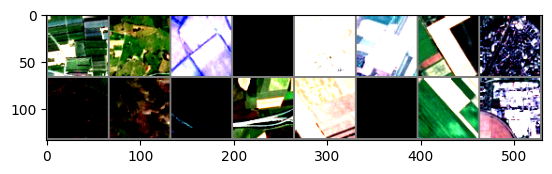

Labels: 6 5 0 1 4 0 0 7 2 2 1 3 0 9 0 4
General Image shape: torch.Size([64, 3, 64, 64])


In [5]:
# Dictionary converting label numbers back to actual names:
num_to_class = {val:ky for ky, val in original_set.class_to_idx.items()}

# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))
print(f'General Image shape: {images.shape}') # batch size, channels, height, width

### Building the CNN class (explained by ChatGPT)
#### 1. Input Dimensions
- Batch Size: The number of images processed in one forward/backward pass (e.g., 32).
- Channels: The number of color channels in the images (e.g., 3 for RGB images).
- Height: The height of each image (e.g., 224 pixels).
- Width: The width of each image (e.g., 224 pixels).

Example Input Dimensions: `(Batch Size, Channels, Height, Width) = (32, 3, 224, 224)`.

#### 2. Convolutional Layer
Parameters to Determine:

- Number of Filters (K): The number of output channels after convolution.
- Filter Size (F): The dimensions of the filter (e.g., 3x3).
- Stride (S): The step size the filter takes as it moves across the image (default is 1).
- Padding (P): Pixels added to the borders of the input image to control the spatial dimensions (e.g., 'valid' or 'same').

Output Dimension Calculation:

For a single convolutional layer, the output dimensions can be calculated using:

\begin{equation*}
\text{Output Height} = \frac{\text{Input Height - \text{Filter Size} + 2$\times$\text{Padding}}}{\text{Stride}} + 1
\end{equation*}

\begin{equation*}
\text{Output Width} = \frac{\text{Input Width - \text{Filter Size} + 2$\times$\text{Padding}}}{\text{Stride}} + 1
\end{equation*}

Example Calculation:

- Input Height = 224, Input Width = 224
- Filter Size = 3x3, Stride = 1, Padding = 1 (assuming 'same' padding)

\begin{equation*}
\text{Output Height} = \frac{224 - 3 + 2 \times 1}{1} + 1 = 224
\end{equation*}

\begin{equation*}
\text{Output Width} = \frac{224 - 3 + 2 \times 1}{1} + 1 = 224 
\end{equation*}

- Number of Filters (K) determines the depth of the output.

#### 3. Pooling Layer

Parameters to Determine:

- Pool Size (P): The size of the pooling window (e.g., 2x2).
- Stride (S): The step size of the pooling operation.

Output Dimension Calculation:

For a pooling layer, the output dimensions are calculated similarly:

\begin{equation*}
\text{Output Height} = \frac{\text{Input Height - \text{Pool Size}}}{\text{Stride}} + 1
\end{equation*}

\begin{equation*}
\text{Output Width} = \frac{\text{Input Width - \text{Pool Size}}}{\text{Stride}} + 1
\end{equation*}

Example Calculation:

- Input Height = 224, Input Width = 224
- Pool Size = 2x2, Stride = 2


\begin{equation*}
\text{Output Height} = \frac{224-2}{2} + 1 = 112
\end{equation*}

\begin{equation*}
\text{Output Width} = \frac{224-2}{2} + 1 = 112
\end{equation*}

Example Output Dimensions: `(Batch Size, Number of Channels, Output Height, Output Width)`

#### 4. Fully Connected Layer
After several convolutional and pooling layers, you typically flatten the output to feed it into fully connected (dense) layers.

Dimensions:

- Flattened Size = Number of Channels × Output Height × Output Width

Example:

- Number of Channels = 64
- Output Height = 112
- Output Width = 112

\begin{equation*}
\text{Flattened Size} = 64 \times 112 \times 112 = 802,816
\end{equation*}

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Define the architecture
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Calculate the size of the flattened output from the conv layers
        # After conv1: (64, 32, 64, 64) -> (64, 32, 64, 64) (since padding=1 and stride=1)
        # After pool1: (64, 32, 64, 64) -> (64, 32, 32, 32)
        # After conv2: (64, 32, 32, 32) -> (64, 64, 32, 32)
        # After pool2: (64, 64, 32, 32) -> (64, 64, 16, 16)
        # After conv3: (64, 64, 16, 16) -> (64, 128, 16, 16)
        # After pool3: (64, 128, 16, 16) -> (64, 128, 8, 8)
        # After conv4: (64, 128, 8, 8) -> (64, 256, 8, 8)
        # After pool4: (64, 256, 8, 8) -> (64, 256, 4, 4)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512) # self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(512, 10)  # Assuming 10 output classes for classification

    def forward(self, x):
        # Pass through the network layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten the tensor
        # x = x.view(-1, 128 * 8 * 8)
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
cnet = SimpleCNN()
print(cnet)

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnet.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnet.parameters())

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Training the Neural Net

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7415432..4.0874004].


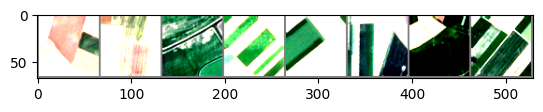

Predicted: 0 0 5 0 0 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7415432..4.0874004].


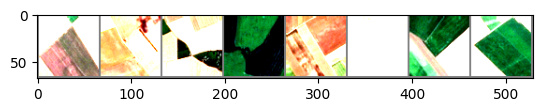

Predicted: 0 6 0 8 6 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2029271..4.2641964].


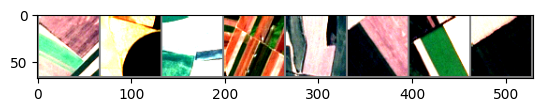

Predicted: 0 0 0 6 0 0 0 0
Epoch 1, Loss: 0.1328030836702319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9544897..5.1373086].


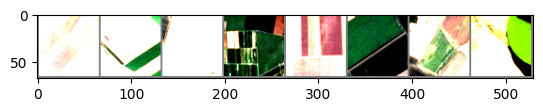

Predicted: 0 0 0 6 0 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39727587..4.173874].


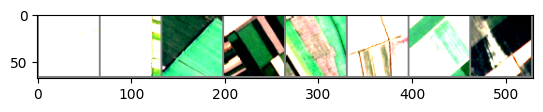

Predicted: 0 0 0 0 0 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9899808..5.197523].


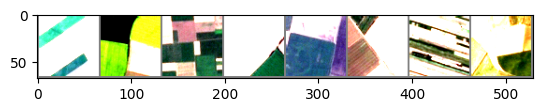

Predicted: 0 0 0 0 0 0 0 0
Epoch 2, Loss: 0.11822825198794698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8480164..4.4448404].


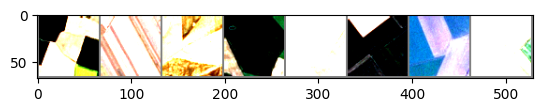

Predicted: 0 6 6 0 0 8 3 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6333114..4.3846254].


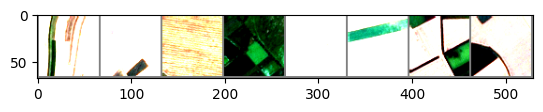

Predicted: 0 0 2 8 0 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7415432..4.0874004].


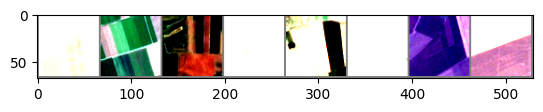

Predicted: 0 0 0 0 0 0 8 0
Epoch 3, Loss: 0.10626307121042669


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.167436..4.0874004].


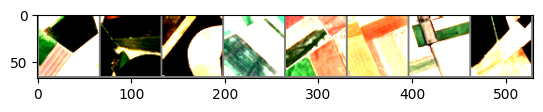

Predicted: 0 1 0 0 0 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0609629..0.8555544].


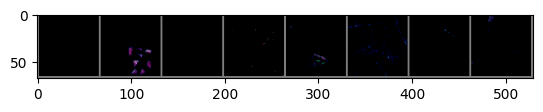

Predicted: 1 9 1 1 1 1 9 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4513645..1.1932489].


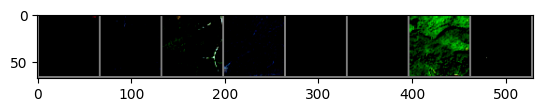

Predicted: 1 1 1 1 1 1 1 1
Epoch 4, Loss: 0.10273690844235732


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3094003..1.5244297].


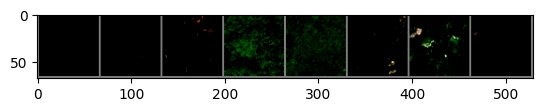

Predicted: 1 1 1 1 1 1 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2739092..1.0427122].


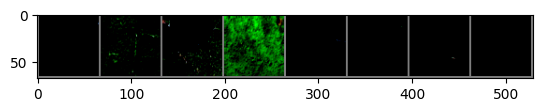

Predicted: 1 1 1 1 1 1 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0254718..0.5].


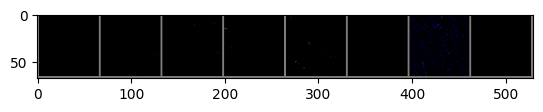

Predicted: 1 1 1 1 1 1 1 1
Epoch 5, Loss: 0.07106161545293913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3094003..1.3169382].


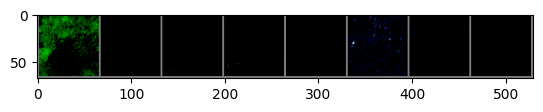

Predicted: 1 1 1 1 1 1 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2384182..2.7365808].


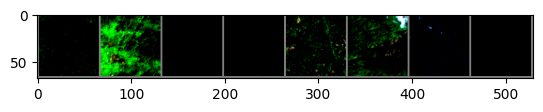

Predicted: 1 1 1 1 1 1 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2153372..1.3524295].


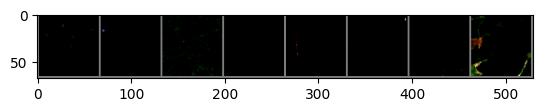

Predicted: 1 1 1 1 1 1 1 5
Epoch 6, Loss: 0.06568799921669295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3448913..1.0330098].


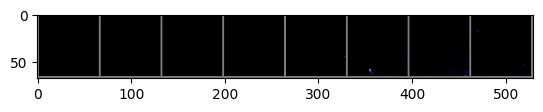

Predicted: 1 1 1 1 1 1 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2739092..5.5403743].


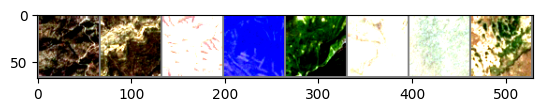

Predicted: 2 2 6 2 1 2 2 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8480164..5.8597937].


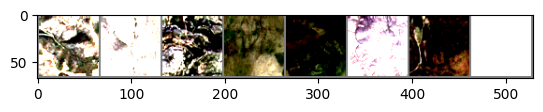

Predicted: 2 2 2 2 5 2 2 2
Epoch 7, Loss: 0.07378968669820753
Finished Training


In [8]:
# Number of training epochs
num_epochs = 7

testiter = iter(testloader)

# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = cnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 150 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = cnet(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')

### Doing Predictions on Test Set

In [9]:
# Evaluate
cnet.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_img, labels in testloader:
        test_outputs = cnet(batch_img)
        _, pred = torch.max(test_outputs, 1)
        all_predictions.extend(pred.numpy())
        all_labels.extend(labels.numpy())

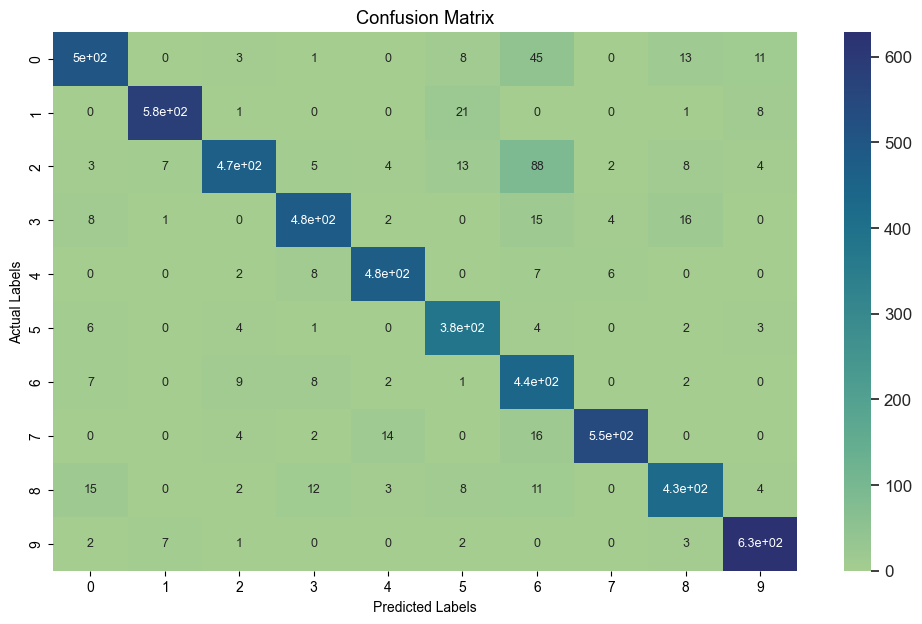

In [10]:
# Create the confusion matrix
pred_results = confusion_matrix(all_labels, all_predictions)
df_preds = pd.DataFrame(pred_results, range(10), range(10))

fig, axes = plt.subplots(figsize=(12, 7))

sns.set(font_scale=1.1)
sns.heatmap(df_preds, annot=True, annot_kws={"size": 9}, cmap="crest") # font size

plt.xlabel('Predicted Labels')
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Get classification scores
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       585
           1       0.97      0.95      0.96       611
           2       0.95      0.78      0.85       602
           3       0.93      0.91      0.92       526
           4       0.95      0.95      0.95       498
           5       0.88      0.95      0.91       401
           6       0.70      0.94      0.80       469
           7       0.98      0.94      0.96       582
           8       0.90      0.89      0.90       482
           9       0.95      0.98      0.97       644

    accuracy                           0.91      5400
   macro avg       0.91      0.91      0.91      5400
weighted avg       0.92      0.91      0.91      5400



In [12]:
num_to_class

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

### Conclusions

To develop the neural network, the first step was to normalize the images. Afterwards, there were 4 convolutional layers to the network where after each layer, the output was passed into a pooling layer to reduce the dimensionality of the image. This was done with $7$ training epochs and the results are summarized in the confusion matrix and in a classification report.

The overall weighted recall was about 91\%. Overall, the model well on average, but there were some categories that it did poorer on like guessing label 2, which was the herbaceous vegetation images.